In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

import umap
import hdbscan
from sklearn.cluster import KMeans

from scipy.stats import skew, kurtosis, f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import jaccard, squareform, pdist

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, pairwise_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('/Users/quentinbacquele/Desktop/Internship/Berkeley/Reunion Gray white-eye/')

In [3]:
data = pd.read_csv('data/pitch_contour_dom4.csv')
meta = pd.read_csv('metadata/filtered_metadata.csv')

In [4]:
meta = meta.drop(['wav_file'], axis='columns')
meta = meta.rename(columns={'Individual_ID': 'bird'})
meta = meta.drop_duplicates(subset='bird', keep='first')

In [5]:
df = pd.merge(data, meta, on='bird', how='left')

In [6]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [7]:
# Group by 'file_name' and calculate the required statistics
grouped = df.groupby('file_name')['pitch_value'].agg(['mean', 'std', lambda x: kurtosis(x, fisher=True), lambda x: skew(x)]).reset_index()
grouped.columns = ['file_name', 'mean', 'std', 'kurtosis', 'skewness']

# Merge the statistics back into the original dataframe
df = pd.merge(df, grouped, on='file_name', how='left')

df.head()

file_name     bird  syllable  pitch_order  pitch_value  \
0  S3_ZB_0071_1148.WAV_3.wav  ZB_0071         3            0     5677.875   
1  S3_ZB_0071_1148.WAV_3.wav  ZB_0071         3            1     5677.875   
2  S3_ZB_0071_1148.WAV_3.wav  ZB_0071         3            2     5733.000   
3  S3_ZB_0071_1148.WAV_3.wav  ZB_0071         3            3     4906.125   
4  S3_ZB_0071_1148.WAV_3.wav  ZB_0071         3            4     4851.000   

  morph pop_code         mean         std  kurtosis  skewness  
0  HIGH    FNDPs  4414.793478  545.564375  0.224452  0.300246  
1  HIGH    FNDPs  4414.793478  545.564375  0.224452  0.300246  
2  HIGH    FNDPs  4414.793478  545.564375  0.224452  0.300246  
3  HIGH    FNDPs  4414.793478  545.564375  0.224452  0.300246  
4  HIGH    FNDPs  4414.793478  545.564375  0.224452  0.300246

In [8]:
df['bird'] = df['bird'].str.replace('m$', '', regex=True)

In [9]:
mean_metrics_by_morph = df.groupby('morph')['mean'].agg(['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))]).reset_index()
mean_metrics_by_morph.columns = ['morph', 'mean', 'SE']

print(mean_metrics_by_morph)

  morph         mean        SE
0   BNB  4084.219047  2.041979
1   GHB  4148.711341  1.358641
2  HIGH  3986.900305  1.045678
3  LBHB  4109.660846  1.435819


In [10]:
f_value, p_value = f_oneway(*[group["mean"].values for name, group in df.groupby("morph")])
print(f"ANOVA test results for 'mean': F-value = {f_value}, p-value = {p_value}")

ANOVA test results for 'mean': F-value = 3597.3886126004522, p-value = 0.0


In [11]:
mod = pairwise_tukeyhsd(endog=df['mean'],     # Data
                        groups=df['morph'],   # Groups
                        alpha=0.05)           # Significance level

print(mod.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower     upper   reject
-------------------------------------------------------
   BNB    GHB  64.4923   0.0   57.4223   71.5623   True
   BNB   HIGH -97.3187   0.0 -104.0764  -90.5611   True
   BNB   LBHB  25.4418   0.0   18.1761   32.7075   True
   GHB   HIGH -161.811   0.0 -166.0986 -157.5235   True
   GHB   LBHB -39.0505   0.0   -44.101     -34.0   True
  HIGH   LBHB 122.7605   0.0  118.1575  127.3636   True
-------------------------------------------------------


In [12]:
def get_series(df):
    series_list = []
    names_list = []
    current_series = []
    previous_order = -1
    for _, row in df.iterrows():
        if row['pitch_order'] == 0 and previous_order != -1:
            series_list.append(current_series)
            names_list.append(f"{row['file_name']} ({row['morph']})")
            current_series = []
        current_series.append(row['pitch_value'])
        previous_order = row['pitch_order']
    if current_series:  # Add the last series if exists
        series_list.append(current_series)
        names_list.append(f"{row['file_name']} ({row['morph']})")
    return series_list, names_list

In [13]:
all_lengths = []

for file_name, group in df.groupby('file_name'):
    series, _ = get_series(group)
    all_lengths.extend([len(s) for s in series])

min_length = min(all_lengths)
max_length = max(all_lengths)
mean_length = np.mean(all_lengths)
sd_length = np.std(all_lengths)

print(f"Minimum length of time series: {min_length}")
print(f"Maximum length of time series: {max_length}")
print(f"Mean length of time series: {mean_length} ± {sd_length}")

Minimum length of time series: 9
Maximum length of time series: 80
Mean length of time series: 36.32097817743173 ± 9.928826091269839


In [14]:
def smooth_extend_to_max_length(values, target_length=80):
    # Subtract the mean of the entire time series from itself
    mean_adjusted_values = values - np.mean(values)
    
    extension_length = target_length - len(mean_adjusted_values)
    if extension_length <= 0:
        return mean_adjusted_values

    # Check if the last value is close to zero
    last_value = mean_adjusted_values[-1]
    if np.isclose(last_value, 0, atol=1e-8):
        extended_values = np.zeros(extension_length)
    else:
        # Create an exponential extension towards zero
        x = np.arange(1, extension_length + 1)
        # Ensure the decay rate is positive and achieves a significant reduction by the end of the extension
        decay_rate = np.log(1 + np.abs(last_value)) / extension_length
        extended_values = last_value * np.exp(-decay_rate * x)

        # Ensure we don't go beyond zero in the direction we are coming from
        if last_value < 0:
            extended_values = np.maximum(extended_values, last_value)
        else:
            extended_values = np.minimum(extended_values, last_value)
    

    # Concatenate the mean-adjusted values with the extended values
    extended_series = np.concatenate([mean_adjusted_values, extended_values]) + np.mean(values)
    
    return extended_series


# Example of using the function with a DataFrame (assuming df is your DataFrame)
extended_series_list = []
for (file_name, syllable), group in df.groupby(['file_name', 'syllable']):
    sorted_group = group.sort_values(by='pitch_order')
    pitch_values = sorted_group['pitch_value'].values
    extended_pitch_values = smooth_extend_to_max_length(pitch_values)
    extended_series = pd.DataFrame({
        'file_name': file_name,
        'bird': sorted_group['bird'].iloc[0],
        'syllable': syllable,
        'pitch_order': range(len(extended_pitch_values)),
        'pitch_value': extended_pitch_values,
        'morph': sorted_group['morph'].iloc[0],
        'pop_code': sorted_group['pop_code'].iloc[0],
    })
    extended_series_list.append(extended_series)

extended_df = pd.concat(extended_series_list).reset_index(drop=True)


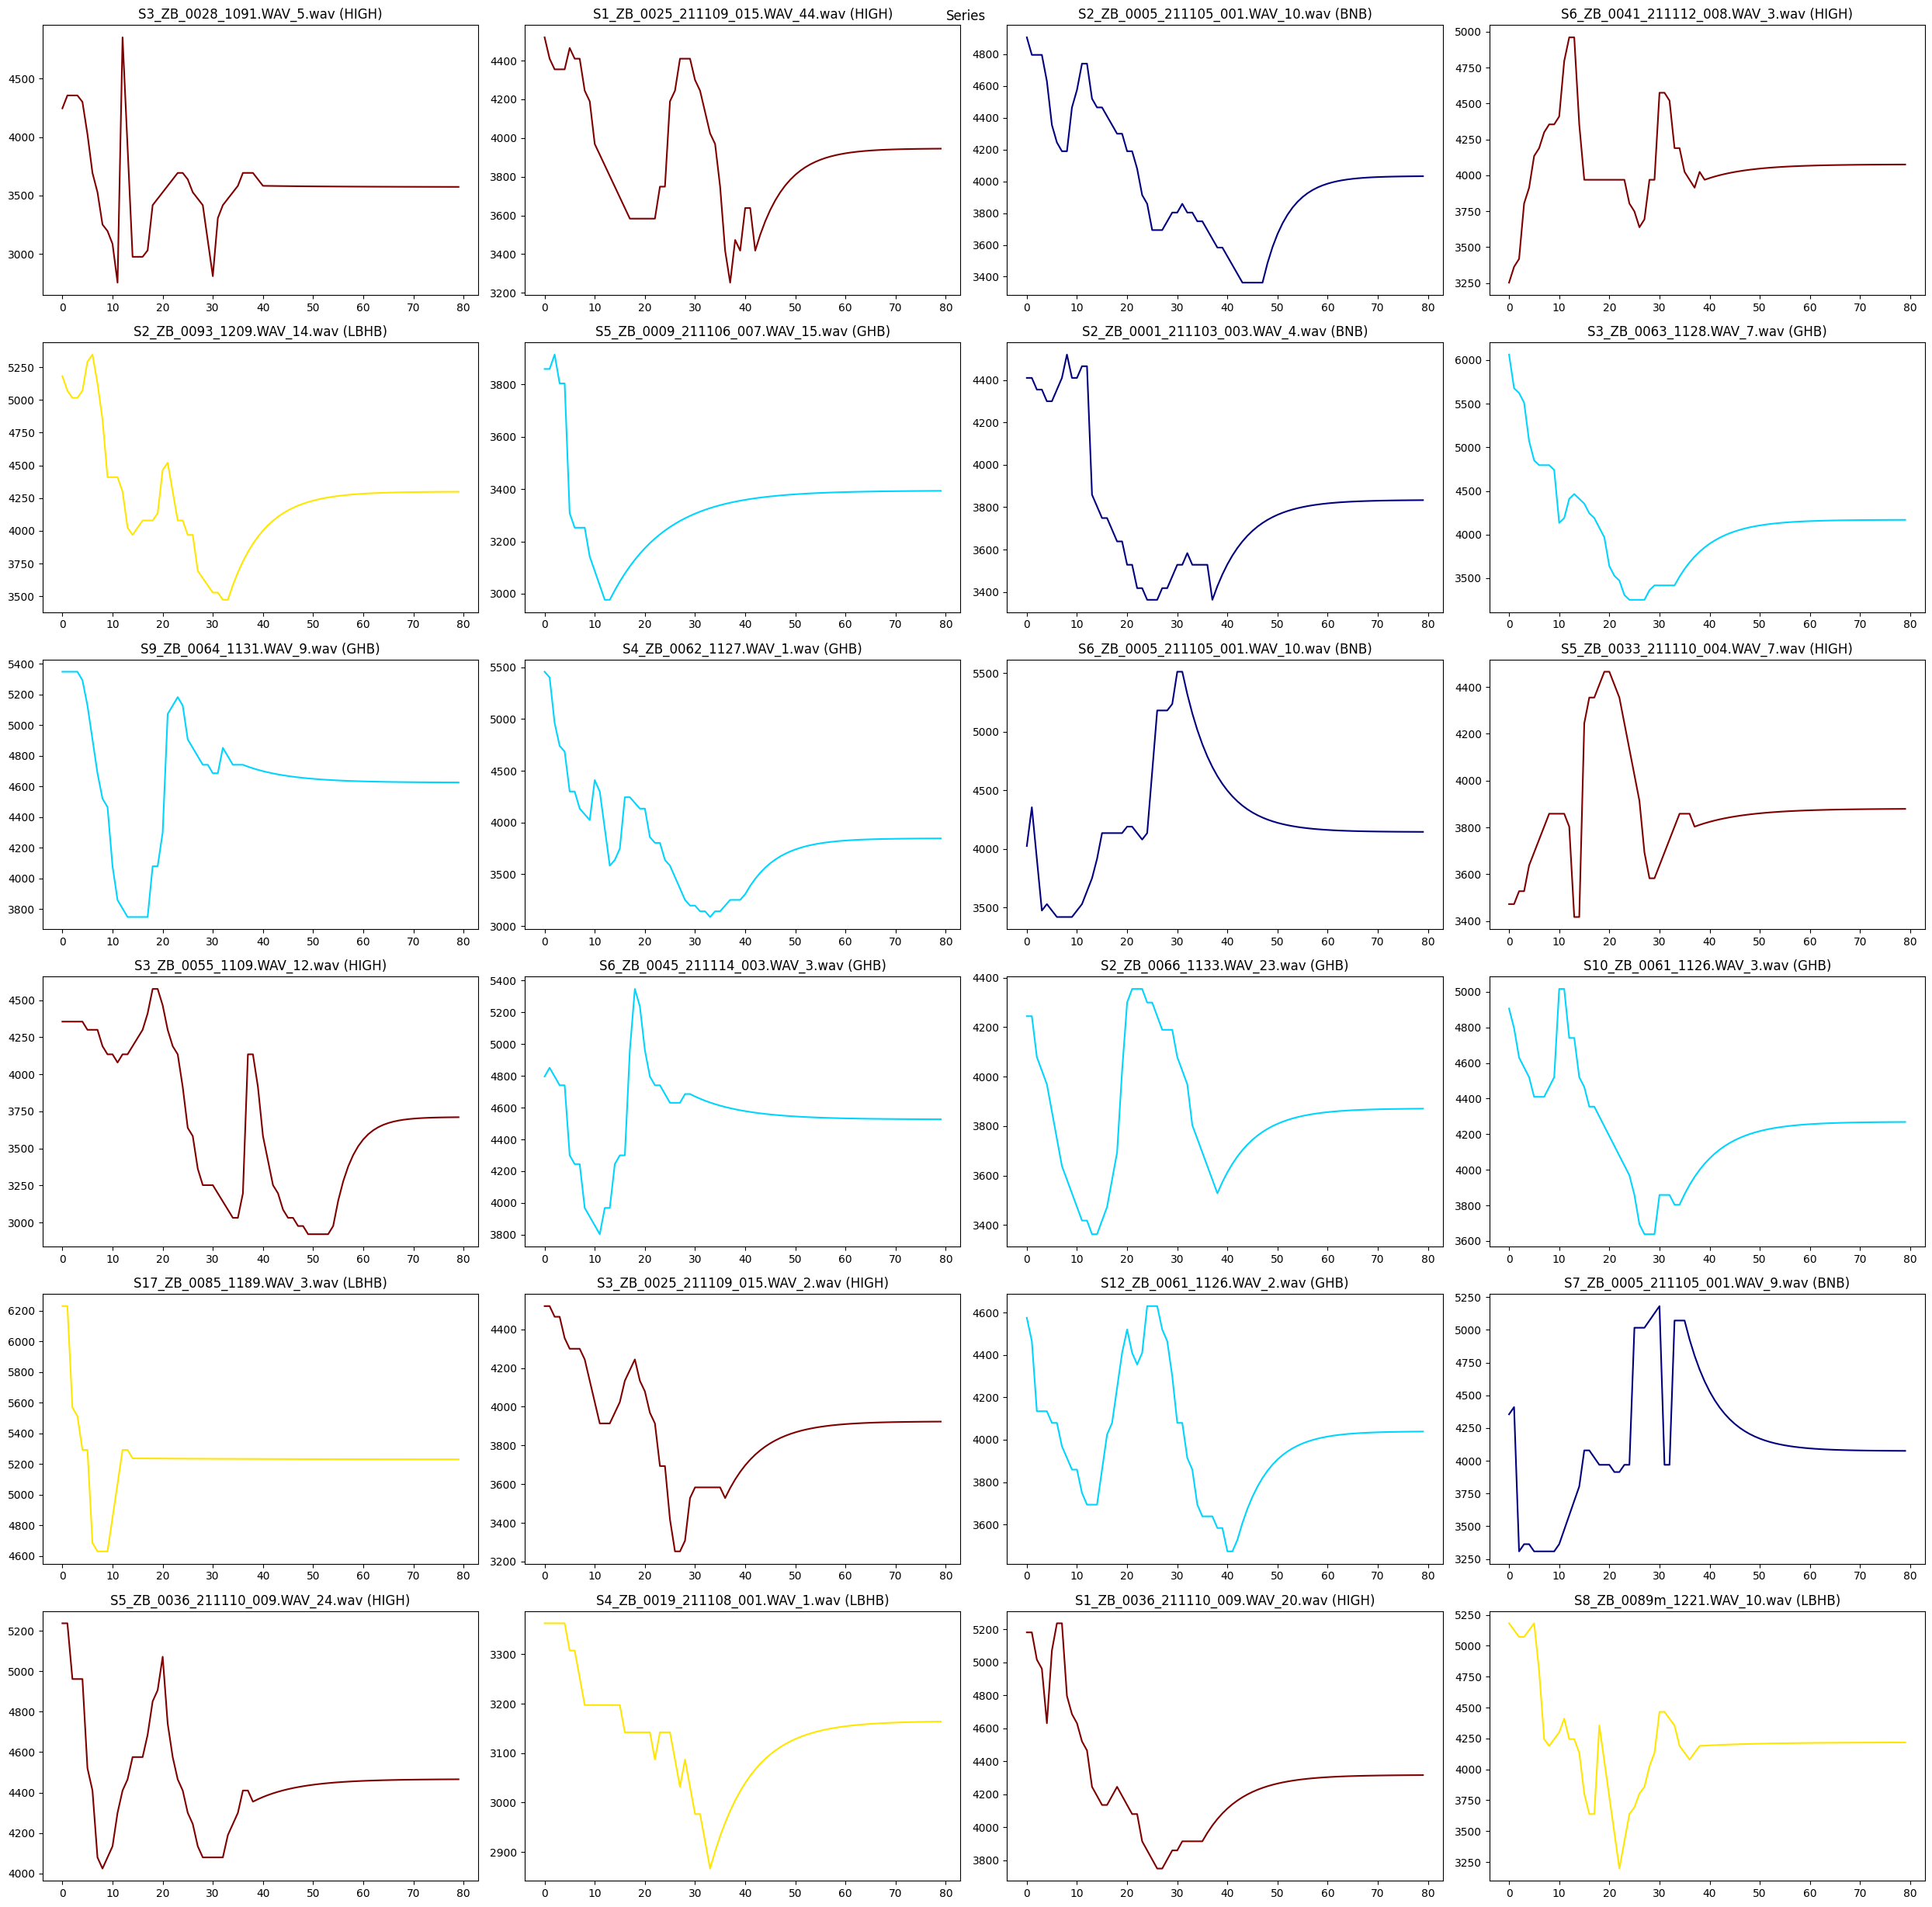

In [15]:

morphs = extended_df['morph'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(morphs)))
morph_colors_dict = {morph: color for morph, color in zip(morphs, colors)}

all_series = []
all_names = []
all_colors = []

for file_name, group in extended_df.groupby('file_name'):
    series, names = get_series(group)
    morph = group.iloc[0]['morph'] 
    color = morph_colors_dict[morph]
    all_series.extend(series)
    all_names.extend(names)
    all_colors.extend([color] * len(series))

num_plots = min(len(all_series), 24)
selected_indices = np.random.choice(range(len(all_series)), size=num_plots, replace=False)

fig, axs = plt.subplots(6, 4, figsize=(25, 25))
fig.suptitle('Series')

for plot_idx, series_idx in enumerate(selected_indices):
    i = plot_idx // 4 
    j = plot_idx % 4  
    series = all_series[series_idx]
    name = all_names[series_idx]
    color = all_colors[series_idx]
    axs[i, j].plot(series, color=color)
    axs[i, j].set_title(name)

if num_plots < 24:
    for ax_idx in range(num_plots, 24):
        i = ax_idx // 4
        j = ax_idx % 4
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Re-assign pitch_order to ensure it's unique within each group
extended_df['pitch_order'] = extended_df.groupby(['file_name', 'bird', 'syllable', 'morph', 'pop_code']).cumcount() + 1

# Pivot the table to wide format
wide_df = extended_df.pivot_table(index=['file_name', 'bird', 'syllable', 'morph', 'pop_code'], 
                                  columns='pitch_order', 
                                  values='pitch_value').reset_index()

# Ensure that columns_to_merge are unique and available in df before merging
columns_to_merge = ['file_name', 'mean', 'std', 'kurtosis', 'skewness']
df_selected = df[columns_to_merge].drop_duplicates(subset=['file_name'])

# Merge wide_df with df_selected, ensure that 'file_name' is a unique key in df_selected
wide_df = pd.merge(wide_df, df_selected, on='file_name', how='left')

wide_df.head()


file_name     bird  syllable morph pop_code  \
0  S10_ZB_0005_211105_001.WAV_10.wav  ZB_0005        10   BNB     TREM   
1   S10_ZB_0005_211105_001.WAV_3.wav  ZB_0005        10   BNB     TREM   
2   S10_ZB_0005_211105_001.WAV_5.wav  ZB_0005        10   BNB     TREM   
3   S10_ZB_0005_211105_001.WAV_6.wav  ZB_0005        10   BNB     TREM   
4   S10_ZB_0005_211105_002.WAV_3.wav  ZB_0005        10   BNB     TREM   

          1         2        3         4         5  ...           75  \
0  4299.750  4189.500  4189.50  4134.375  4134.375  ...  4027.378908   
1  5622.750  5292.000  5292.00  4961.250  4906.125  ...  4019.016116   
2  3858.750  3858.750  3858.75  3913.875  3913.875  ...  3661.015614   
3  3803.625  3858.750  3858.75  3803.625  3803.625  ...  3661.613324   
4  4906.125  4906.125  4851.00  4244.625  4079.250  ...  4066.372661   

            76           77           78           79           80  \
0  4027.263358  4027.156856  4027.058694  4026.968217  4026.884825   
1  4019.524928  4019.940046  4020.278723  4020.555035  4020.780467   
2  3661.198776  3661.362596  3661.509115  3661.640160  3661.757366   
3  3661.824926  3662.012149  3662.177802  3662.324371  3662.454054   
4  4066.588754  4066.779637  4066.948252  4067.097196  4067.228765   

          mean         std  kurtosis  skewness  
0  4025.903226  173.437344 -1.399992  0.028570  
1  4021.779255  607.023673 -0.202060  0.711158  
2  3662.750000  198.294383 -1.167744 -0.539746  
3  3663.450000  197.104631 -1.215295 -0.439641  
4  4068.225000  327.163645  0.891572  1.221033  

[5 rows x 89 columns]

In [17]:
wide_df.drop_duplicates(inplace=True)

In [18]:
bird_counts = wide_df['bird'].value_counts()
wide_df['weights'] = wide_df['bird'].map(bird_counts)

In [19]:
weighted_means = np.zeros(80)
for i in range(1, 81):
    # 𝝁=1/∑𝑤𝑖(∑𝑤𝑖𝐱𝑖)
    weighted_means[i-1] = (wide_df[i] * wide_df['weights']).sum() / wide_df['weights'].sum()
    wide_df[i] = wide_df[i] - weighted_means[i-1]
    
    # #𝑠2 =1/𝑉1−1(∑𝑁𝑖=1𝑤𝑖(𝑥𝑖−𝜇∗)**2)
    # V1 = wide_df['weights'].sum()
    # weighted_variance = (wide_df['weights'] * (wide_df[i] ** 2)).sum() / (V1 - 1)
    # wide_df[i] = wide_df[i] / np.sqrt(weighted_variance)

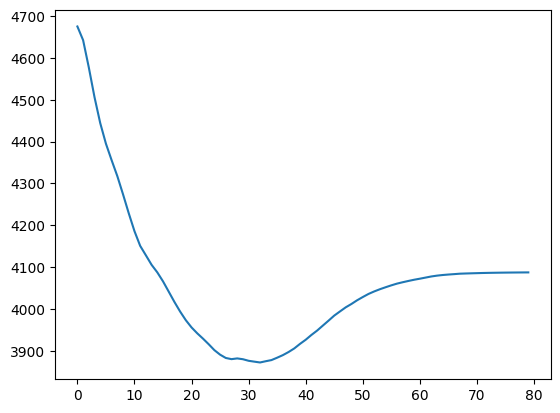

In [20]:
plt.plot(weighted_means)

In [21]:
X = wide_df.drop(columns=['syllable', 'bird', 'morph', 'pop_code', 'file_name', 'mean', 'std', 'kurtosis', 'skewness', 'weights'])  
X.columns = X.columns.astype(str)
y = wide_df['morph'].values

n_samples, n_features = X.shape

print('Number of samples:', n_samples)
print('Number of features:', n_features)

Number of samples: 9119
Number of features: 80


In [22]:
data_matrix = wide_df[[i for i in range(1, 81)]].values
weights = wide_df['weights'].values
W = np.diag(weights)
cov_matrix = (data_matrix.T @ W @ data_matrix) / np.sum(weights)

In [23]:
from numpy.linalg import eig

# Eigendecomposition of covariance matrix
eig_vals, eig_vecs = eig(cov_matrix) 

# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs = eig_vecs*signs[np.newaxis,:]
eig_vecs = eig_vecs.T

In [24]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

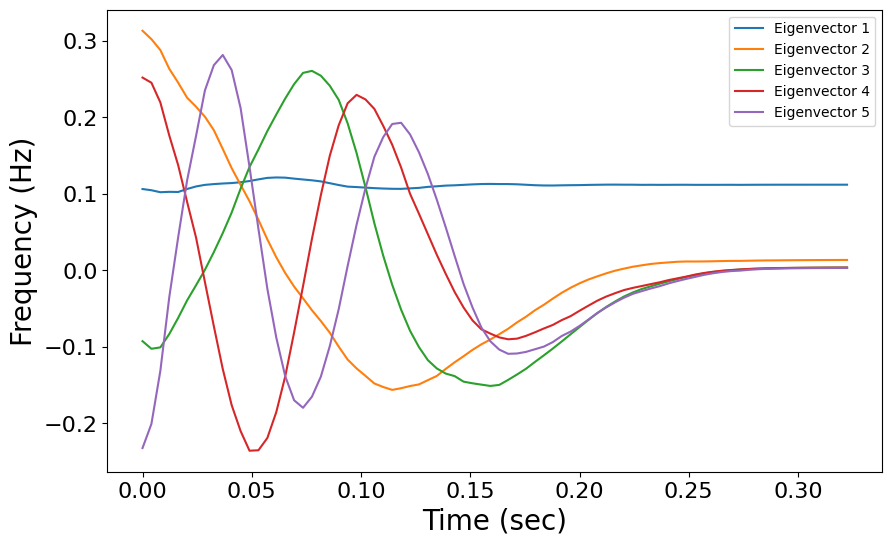

In [25]:
Fs = 44100  # Sampling frequency
window_size = 180

# Select top k eigenvectors
k = 5
Z = eig_vecs_sorted[:k, :]  # Projection matrix

# Convert x-axis units to time
num_points = Z.shape[1]
time = np.arange(num_points) * window_size / Fs  # Convert index to time in seconds

# Plot the top k eigenvectors with time on the x-axis
plt.figure(figsize=(10, 6))
for i in range(k):
    plt.plot(time, Z[i, :], label=f'Eigenvector {i+1}')
plt.xlabel('Time (sec)', fontsize=20)
plt.ylabel('Frequency (Hz)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.savefig('top_k_eigenvectors.png', dpi=600, bbox_inches='tight')
plt.show()


Number of components to retain 90% of variance: 4


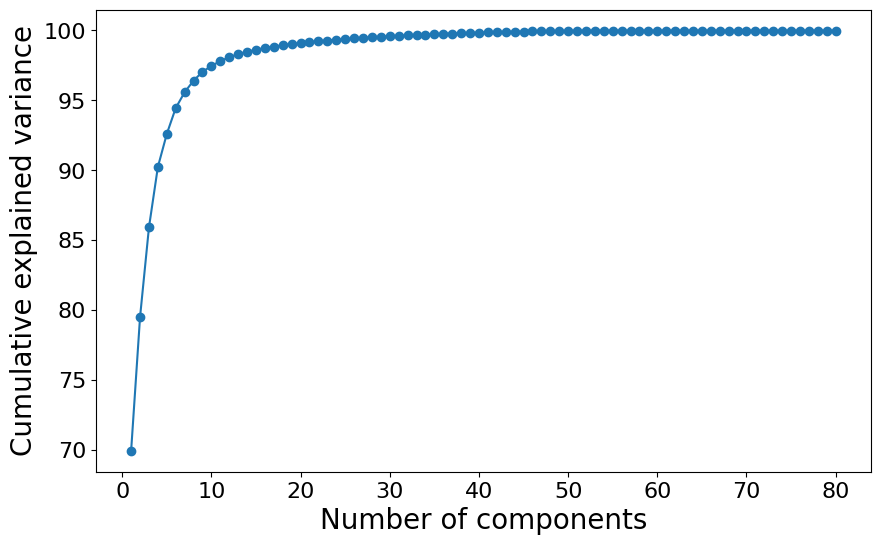

In [26]:
threshold_variance = 90
eig_vals_total = sum(eig_vals)
explained_variance = [(i / eig_vals_total)*100 for i in eig_vals_sorted]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)
n_components = np.where(cum_explained_variance >= threshold_variance)[0][0] + 1

print(f"Number of components to retain {threshold_variance}% of variance: {n_components}")

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1,n_features+1), cum_explained_variance, '-o')
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('Cumulative explained variance', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('explained_variance.png', dpi=600, bbox_inches='tight')
plt.show()

# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

top_k = 5
eig_vecs_sorted = eig_vecs_sorted[:top_k, :]
principal_components = data_matrix @ eig_vecs_sorted.T

reconstructed_data = np.dot(principal_components, eig_vecs_sorted)
first_time_series_reconstructed = reconstructed_data[1712, :] + wide_df.iloc[1712, 85]

num_points = first_time_series_reconstructed.shape[0]
time = np.arange(num_points) * window_size / Fs  # Convert index to time in seconds

# Plot the reconstructed first time series with time on the x-axis
plt.figure(figsize=(3, 6))
plt.plot(time, first_time_series_reconstructed, label='Reconstructed First Time Series', color = 'red', linewidth=2)
plt.xlabel('Time (sec)', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.ylim(2000,6500)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('reconstructed_first_time_series_S1.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [27]:
X_proj = X.dot(Z.T)
print(X_proj.shape)

(9119, 5)


In [28]:
unique_labels = np.unique(y)
label_to_numeric = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels = np.array([label_to_numeric[label] for label in y])

plt.figure(figsize=(9, 9))
plt.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c=numeric_labels, cmap='Set1', alpha=0.65, s=3)
plt.xlabel('PC1'); plt.xticks([])
plt.ylabel('PC2'); plt.yticks([])
plt.title('2 components, captures {} of total variation'.format(cum_explained_variance[1]))
plt.show()

In [29]:
eig_vals_sorted = eig_vals_sorted[:5]
eig_vecs_sorted = eig_vecs_sorted[:5, :]
principal_components = data_matrix @ eig_vecs_sorted.T
X_PCA_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
X_PCA_df.head()

PC1          PC2          PC3         PC4         PC5
0  -264.965887 -1146.158738  -550.017012 -212.814060  440.067267
1  -775.794312  2070.240025  1387.080254  532.194230  250.761668
2 -3678.844571  -527.813442   510.560154 -601.426485 -317.472240
3 -3748.660363  -716.843969   809.656979 -641.403205 -450.528437
4  -177.933775   158.722686  -226.838426 -142.623374  -10.167379

In [30]:
#stats_columns = wide_df[['syllable', 'bird', 'morph', 'pop_code', 'file_name', 'mean']]
stats_columns = wide_df[['syllable', 'bird', 'morph', 'pop_code', 'file_name']]
stats_columns = stats_columns.reset_index(drop=True)
final_df = pd.concat([stats_columns, X_PCA_df], axis=1)
final_df.head()

syllable     bird morph pop_code                          file_name  \
0        10  ZB_0005   BNB     TREM  S10_ZB_0005_211105_001.WAV_10.wav   
1        10  ZB_0005   BNB     TREM   S10_ZB_0005_211105_001.WAV_3.wav   
2        10  ZB_0005   BNB     TREM   S10_ZB_0005_211105_001.WAV_5.wav   
3        10  ZB_0005   BNB     TREM   S10_ZB_0005_211105_001.WAV_6.wav   
4        10  ZB_0005   BNB     TREM   S10_ZB_0005_211105_002.WAV_3.wav   

           PC1          PC2          PC3         PC4         PC5  
0  -264.965887 -1146.158738  -550.017012 -212.814060  440.067267  
1  -775.794312  2070.240025  1387.080254  532.194230  250.761668  
2 -3678.844571  -527.813442   510.560154 -601.426485 -317.472240  
3 -3748.660363  -716.843969   809.656979 -641.403205 -450.528437  
4  -177.933775   158.722686  -226.838426 -142.623374  -10.167379

In [31]:
Xfinal = final_df.drop(columns=['syllable', 'bird', 'morph', 'pop_code', 'file_name'])  
yfinal = final_df['morph']
yfinal_encoded = final_df['morph'].values

/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


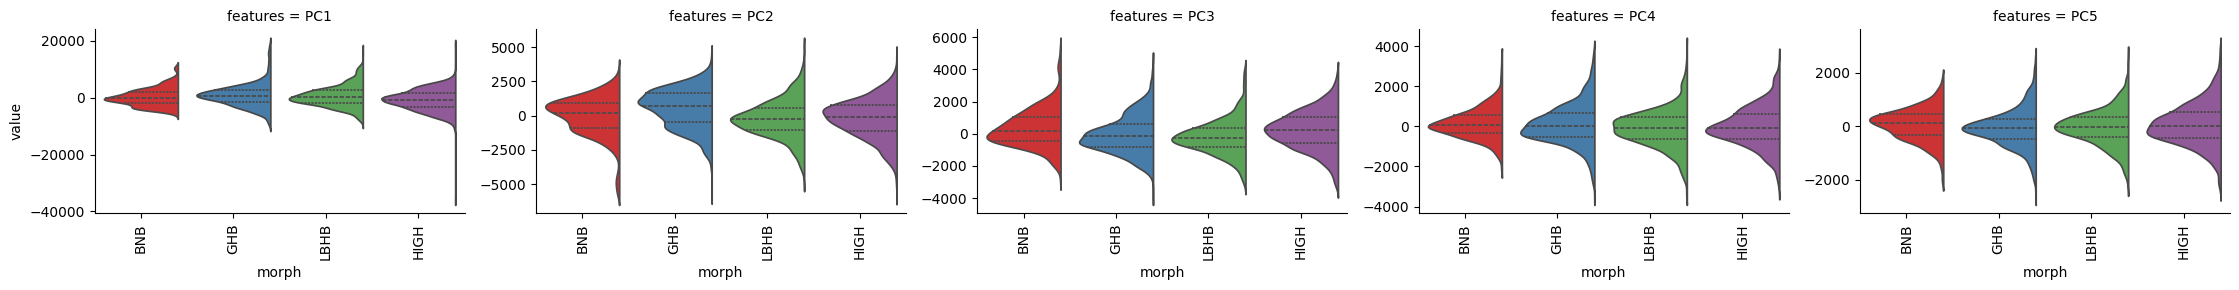

In [32]:
Xfinal['morph'] = yfinal

data_melted = pd.melt(Xfinal, id_vars='morph', var_name='features', value_name='value')

g = sns.FacetGrid(data_melted, col='features', col_wrap=5, sharex=False, sharey=False, hue='morph', aspect=1.5, palette='Set1')
g.map(sns.violinplot, 'morph', 'value', split=True, inner='quart')
g.set_xticklabels(rotation=90)

plt.tight_layout()
plt.show()

In [33]:
Xfinal.drop(columns=['morph'], inplace=True) 

Average Accuracy: 0.5049
Average Recall: 0.5049
Average Precision: 0.5070


/var/folders/12/ks7q36dj491dw0thmdw9zz_40000gn/T/ipykernel_5610/3834624646.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(morph_labels))
/var/folders/12/ks7q36dj491dw0thmdw9zz_40000gn/T/ipykernel_5610/3834624646.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(morph_labels))


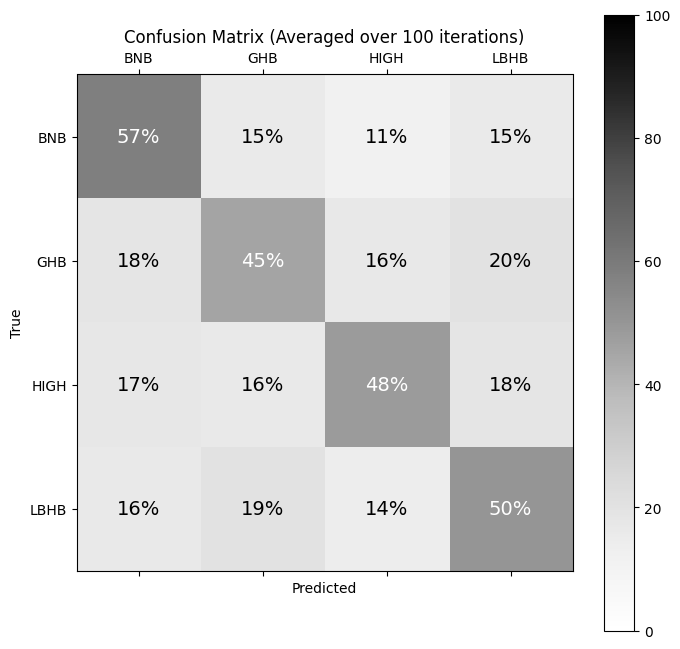

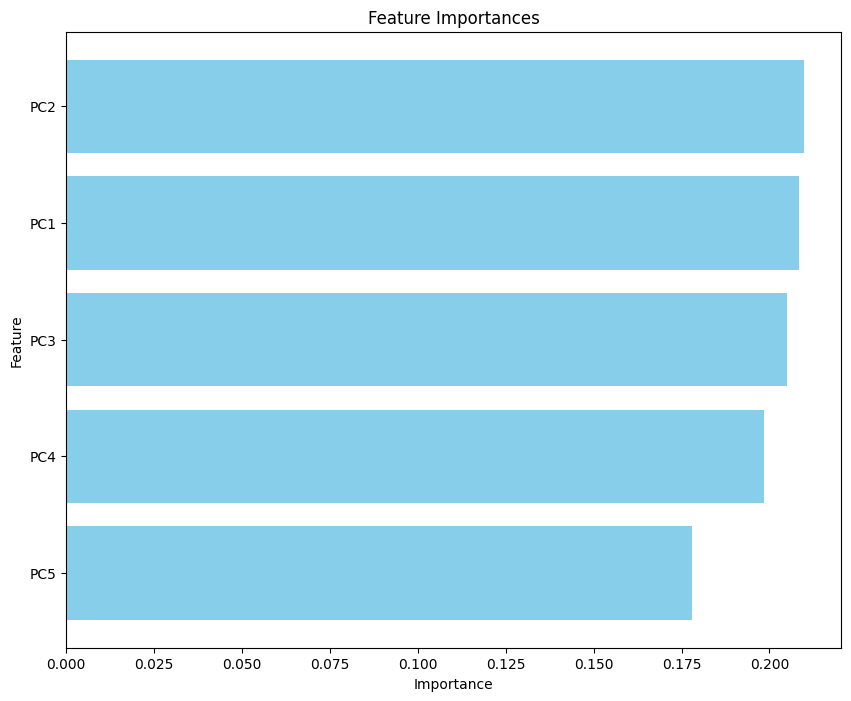

In [34]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming the data is loaded in a DataFrame named 'final_df'

birds = np.unique(final_df['bird'])
train_birds, test_birds = train_test_split(birds, test_size=0.2, random_state=42)

train_idx = final_df['bird'].isin(train_birds)
test_idx = final_df['bird'].isin(test_birds)

# Define features and target
features = final_df.iloc[:, [i for i in range(5, 10)]]
target = 'morph'

X_train = features.loc[train_idx].values
y_train = final_df.loc[train_idx, target].values
X_test = features.loc[test_idx].values
y_test = final_df.loc[test_idx, target].values

# Classifier
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

# Initialize metrics
n_iterations = 100
accuracies, recalls, precisions = [], [], []
conf_matrix_sum = None

# Run the model multiple times
for iteration in range(n_iterations):
    # Analyze class distribution and resample
    class_labels, counts = np.unique(y_train, return_counts=True)
    min_samples = np.min(counts)

    X_resampled = []
    y_resampled = []

    for label in class_labels:
        idx = np.where(y_train == label)[0]
        resampled_idx = np.random.choice(idx, min_samples, replace=False)
        X_resampled.append(X_train[resampled_idx])
        y_resampled.append(y_train[resampled_idx])

    X_resampled = np.concatenate(X_resampled)
    y_resampled = np.concatenate(y_resampled)

    # Stratified K-Fold on the resampled data
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, test_idx in cv.split(X_resampled, y_resampled):
        X_train_fold, X_test_fold = X_resampled[train_idx], X_resampled[test_idx]
        y_train_fold, y_test_fold = y_resampled[train_idx], y_resampled[test_idx]

        rf_clf.fit(X_train_fold, y_train_fold)
        y_pred_fold = rf_clf.predict(X_test_fold)

        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
        recalls.append(recall_score(y_test_fold, y_pred_fold, average='weighted'))
        precisions.append(precision_score(y_test_fold, y_pred_fold, average='weighted'))
        
        conf_matrix = confusion_matrix(y_test_fold, y_pred_fold)
        if conf_matrix_sum is None:
            conf_matrix_sum = conf_matrix
        else:
            conf_matrix_sum += conf_matrix

# Compute average metrics
average_accuracy = np.mean(accuracies)
average_recall = np.mean(recalls)
average_precision = np.mean(precisions)

# Display results
print(f'Average Accuracy: {average_accuracy:.4f}')
print(f'Average Recall: {average_recall:.4f}')
print(f'Average Precision: {average_precision:.4f}')

morph_labels = final_df['morph'].unique()
morph_labels = np.sort(morph_labels)  # Ensure the labels are in the correct order

# Visualize the averaged confusion matrix
conf_matrix_percentage = conf_matrix_sum.astype('float') / conf_matrix_sum.sum(axis=1)[:, np.newaxis]*100

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(conf_matrix_percentage, cmap=plt.cm.Greys, vmin=0, vmax=100)
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Averaged over 100 iterations)')

# Set x and y labels with morph names
ax.set_xticklabels([''] + list(morph_labels))
ax.set_yticklabels([''] + list(morph_labels))

thresh = conf_matrix_percentage.max() / 2.
for i in range(conf_matrix_percentage.shape[0]):
    for j in range(conf_matrix_percentage.shape[1]):
        text = f"{int(conf_matrix_percentage[i, j])}%"  # Format as whole number percentage
        ax.text(j, i, text, ha='center', va='center', fontsize=14, color="white" if conf_matrix_percentage[i, j] > thresh else "black")

plt.savefig('conf_mat_rf_contour.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

# Get feature importances from the trained classifier
feature_importances = rf_clf.feature_importances_
feature_names = features.columns

# Create a DataFrame to hold feature names and their importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importances in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the histogram of feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.savefig('features_importance_pitch_contour.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()


import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

birds = np.unique(final_df['bird'])
train_birds, test_birds = train_test_split(birds, test_size=0.2, random_state=42)

train_idx = final_df['bird'].isin(train_birds)
test_idx = final_df['bird'].isin(test_birds)

# Define features and target
features = final_df.iloc[:, [i for i in range(5, 10)]]
target = 'morph'

X_train = features.loc[train_idx].values
y_train = final_df.loc[train_idx, target].values
X_test = features.loc[test_idx].values
y_test = final_df.loc[test_idx, target].values

# Classifier
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

# Initialize storage for probabilities
probabilities_list = []

# Number of iterations
n_iterations = 100

# Run the model multiple times
for iteration in range(n_iterations):
    # Analyze class distribution and resample
    class_labels, counts = np.unique(y_train, return_counts=True)
    min_samples = np.min(counts)

    X_resampled = []
    y_resampled = []

    for label in class_labels:
        idx = np.where(y_train == label)[0]
        resampled_idx = np.random.choice(idx, min_samples, replace=False)
        X_resampled.append(X_train[resampled_idx])
        y_resampled.append(y_train[resampled_idx])

    X_resampled = np.concatenate(X_resampled)
    y_resampled = np.concatenate(y_resampled)

    # Fit the classifier on the resampled data
    rf_clf.fit(X_resampled, y_resampled)

    # Obtain predicted probabilities for all samples
    probabilities = rf_clf.predict_proba(features.values)
    probabilities_list.append(probabilities)

# Compute the mean probabilities over all iterations
mean_probabilities = np.mean(probabilities_list, axis=0)

# Add the mean probabilities to the original DataFrame
for i, class_label in enumerate(rf_clf.classes_):
    final_df[f'prob_{class_label}'] = mean_probabilities[:, i]

# Compute the mean probability by song while retaining the 'bird' column
mean_prob_by_song = final_df.groupby(['file_name', 'bird'])[[f'prob_{class_label}' for class_label in rf_clf.classes_]].mean().reset_index()

# Compute the mean probability by bird
mean_prob_by_bird = mean_prob_by_song.groupby('bird')[[f'prob_{class_label}' for class_label in rf_clf.classes_]].mean()

# Extract the prior probabilities for each bird
bird_posteriors = mean_prob_by_bird[[f'prob_{class_label}' for class_label in rf_clf.classes_]]

# Convert to an array if needed
bird_posteriors_array = bird_posteriors.values

# Add columns for predicted morphs
# morph_predicted_bird_pcs
final_df['morph_predicted_bird_pcs'] = final_df['bird'].map(
    lambda b: rf_clf.classes_[np.argmax(bird_posteriors.loc[b].values)]
)

# morph_predicted_sy_pcs
final_df['morph_predicted_sy_pcs'] = rf_clf.classes_[np.argmax(mean_probabilities, axis=1)]

# Display final DataFrame
final_df.head()

bird_prob_copy = mean_prob_by_bird.copy()
bird_prob_copy = bird_prob_copy.reset_index()
bird_prob_copy = bird_prob_copy.rename(columns={'index': 'bird'})

tsne_post_df = pd.merge(bird_prob_copy, final_df[['bird', 'morph']], on='bird', how='left')
tsne_post_df.drop_duplicates(inplace=True)

X_post = tsne_post_df.iloc[:,1:5]

tsne_post = TSNE(n_components=2, perplexity=50, random_state=42, n_iter=10000)  
X_tsne_post = tsne_post.fit_transform(X_post)

tsne_post_df['t-SNE 1 post'] = X_tsne_post[:, 0]
tsne_post_df['t-SNE 2 post'] = X_tsne_post[:, 1]

unique_morphs = tsne_post_df['morph'].unique()
colors = ["#f8786f", "#15c4c8", "#89b61b", "#c87eff"]
color_map = dict(zip(unique_morphs, colors))

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

for morph, color in color_map.items():
    subset = tsne_post_df[final_df['morph'] == morph]
    plt.scatter(subset['t-SNE 1 post'], subset['t-SNE 2 post'], label=morph, color=color, alpha=1, s=20)

plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.savefig('tsne_posteriors_pcs.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

X_post = final_df.iloc[:,10:14]

tsne_post = TSNE(n_components=2, perplexity=15, random_state=42, n_iter=5000)  
X_tsne_post = tsne_post.fit_transform(X_post)

final_df['t-SNE 1 post'] = X_tsne_post[:, 0]
final_df['t-SNE 2 post'] = X_tsne_post[:, 1]

unique_morphs = final_df['morph'].unique()
colors = ["#f8786f", "#15c4c8", "#89b61b", "#c87eff"]
color_map = dict(zip(unique_morphs, colors))

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

for morph, color in color_map.items():
    subset = final_df[final_df['morph'] == morph]
    plt.scatter(subset['t-SNE 1 post'], subset['t-SNE 2 post'], label=morph, color=color, alpha=1, s=7)

plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.savefig('tsne_posteriors.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

distance_matrix = pdist(bird_priors_array, metric='euclidean')

# Create a DataFrame for the distance matrix
distance_df = pd.DataFrame(
    squareform(distance_matrix),
    index=bird_posteriors.index,
    columns=bird_posteriors.index
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap

# Perform hierarchical clustering
linkage_matrix = linkage(distance_df, method='complete')

# Map 'morph' values to colors for the leaves
colors = ["#f8786f", "#15c4c8", "#89b61b","#c87eff"]
morph_colors = {morph: color for morph, color in zip(final_df['morph'].unique(), colors)}
leaf_colors = {bird: morph_colors[final_df.loc[final_df['bird'] == bird, 'morph'].values[0]] for bird in distance_df.index}

# Custom color palette for dendrogram clusters
cmap = LinearSegmentedColormap.from_list('blues', ['#0D47A1', '#42A5F5'], N=256)

# Determine the major morph color for each cluster link
def get_major_morph_color(linkage_matrix, leaf_colors, final_df, num_leaves):
    link_cols = {}
    for i, (node1, node2, dist, _) in enumerate(linkage_matrix):
        node1, node2 = int(node1), int(node2)
        
        # Get leaves in the current cluster
        if node1 < num_leaves:
            leaves1 = [distance_df.index[node1]]
        else:
            leaves1 = link_cols[node1]['leaves']

        if node2 < num_leaves:
            leaves2 = [distance_df.index[node2]]
        else:
            leaves2 = link_cols[node2]['leaves']

        current_leaves = leaves1 + leaves2

        # Determine the most common morph color
        morph_counts = Counter(final_df.loc[final_df['bird'].isin(current_leaves), 'morph'])
        major_morph = morph_counts.most_common(1)[0][0]
        color = morph_colors[major_morph]

        link_cols[i + num_leaves] = {
            'color': color,
            'leaves': current_leaves
        }
    
    return {k: v['color'] for k, v in link_cols.items()}

# Get the link colors
color_threshold = max(linkage_matrix[:, 2]) * 0
num_leaves = len(distance_df.index)
link_colors = get_major_morph_color(linkage_matrix, leaf_colors, final_df, num_leaves)

# Plot the dendrogram
plt.figure(figsize=(10, 20))
dendro = dendrogram(
    linkage_matrix,
    labels=distance_df.index,
    leaf_rotation=0,  # Horizontal text
    leaf_font_size=12,  # Reduced font size
    above_threshold_color='black',
    color_threshold=color_threshold,
    orientation='right',
    link_color_func=lambda k: 'black' if linkage_matrix[k - num_leaves, 2] > color_threshold else link_colors.get(k, '#808080')  # Default to gray if not in link_colors
)

# Color the leaves
ax = plt.gca()
ylbls = ax.get_ymajorticklabels()  # For 'right' orientation, use y-axis labels
for lbl in ylbls:
    lbl.set_color(leaf_colors[lbl.get_text()])

# Create a custom legend
patches = [plt.Line2D([0], [0], color=color, marker='o', linestyle='') for color in morph_colors.values()]
plt.legend(patches, morph_colors.keys(), title="Morph", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlabel(' ')
plt.xticks([])
plt.ylabel('Bird ID', fontsize=20)

# Save the figure
plt.savefig('dendrogram_posteriors_pcs.png', bbox_inches='tight', dpi=600)

plt.show()


import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

birds = np.unique(final_df['bird'])
train_birds, test_birds = train_test_split(birds, test_size=0.2, random_state=42)

train_idx = final_df['bird'].isin(train_birds)
test_idx = final_df['bird'].isin(test_birds)

# Define features and target
features = final_df.drop(columns=['syllable', 'bird', 'morph', 'pop_code', 'file_name'])
target = 'morph'

X_train = features.loc[train_idx].values
y_train = final_df.loc[train_idx, target].values
X_test = features.loc[test_idx].values
y_test = final_df.loc[test_idx, target].values

# Classifier
lda_clf = LinearDiscriminantAnalysis()

# Initialize metrics
n_iterations = 100
accuracies, recalls, precisions = [], [], []
conf_matrix_sum = None

# Run the model multiple times
for iteration in range(n_iterations):
    # Analyze class distribution and resample
    class_labels, counts = np.unique(y_train, return_counts=True)
    min_samples = np.min(counts)

    X_resampled = []
    y_resampled = []

    for label in class_labels:
        idx = np.where(y_train == label)[0]
        resampled_idx = np.random.choice(idx, min_samples, replace=False)
        X_resampled.append(X_train[resampled_idx])
        y_resampled.append(y_train[resampled_idx])

    X_resampled = np.concatenate(X_resampled)
    y_resampled = np.concatenate(y_resampled)

    # Stratified K-Fold on the resampled data
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, test_idx in cv.split(X_resampled, y_resampled):
        X_train_fold, X_test_fold = X_resampled[train_idx], X_resampled[test_idx]
        y_train_fold, y_test_fold = y_resampled[train_idx], y_resampled[test_idx]

        lda_clf.fit(X_train_fold, y_train_fold)
        y_pred_fold = lda_clf.predict(X_test_fold)

        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
        recalls.append(recall_score(y_test_fold, y_pred_fold, average='weighted'))
        precisions.append(precision_score(y_test_fold, y_pred_fold, average='weighted'))
        
        conf_matrix = confusion_matrix(y_test_fold, y_pred_fold)
        if conf_matrix_sum is None:
            conf_matrix_sum = conf_matrix
        else:
            conf_matrix_sum += conf_matrix

# Compute average metrics
average_accuracy = np.mean(accuracies)
average_recall = np.mean(recalls)
average_precision = np.mean(precisions)

# Display results
print(f'Average Accuracy: {average_accuracy:.4f}')
print(f'Average Recall: {average_recall:.4f}')
print(f'Average Precision: {average_precision:.4f}')

# Visualize the averaged confusion matrix
conf_matrix_percentage = conf_matrix_sum.astype('float') / conf_matrix_sum.sum(axis=1)[:, np.newaxis]*100

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(conf_matrix_percentage, cmap=plt.cm.Greys, vmin=0, vmax=100)
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Averaged over 100 iterations)')

thresh = conf_matrix_percentage.max() / 2.
for i in range(conf_matrix_percentage.shape[0]):
    for j in range(conf_matrix_percentage.shape[1]):
        text = f"{int(conf_matrix_percentage[i, j])}%"  # Format as whole number percentage
        ax.text(j, i, text, ha='center', va='center', color="black", fontsize=14,)

plt.savefig('conf_mat_lda_contour.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

# Transform the data to LDA components for plotting
X_train_lda = lda_clf.transform(X_train)
X_test_lda = lda_clf.transform(X_test)

# Combine train and test sets for plotting
X_lda = np.vstack((X_train_lda, X_test_lda))
y_lda = np.concatenate((y_train, y_test))

# Create a DataFrame for easier plotting
lda_df = pd.DataFrame(X_lda, columns=[f'LDA{i+1}' for i in range(X_lda.shape[1])])
lda_df['morph'] = y_lda

# Plot the first two LDA components
unique_morphs = final_df['morph'].unique()
colors = ["#f8786f", "#15c4c8", "#89b61b","#c87eff"]
color_map = dict(zip(unique_morphs, colors))

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

for morph, color in color_map.items():
    subset = lda_df[lda_df['morph'] == morph]
    plt.scatter(subset['LDA1'], subset['LDA2'], label=morph, color=color, alpha=0.75, s=6)

plt.xlabel('LDA1', fontsize=14)
plt.ylabel('LDA2', fontsize=14)
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.savefig('lda_contour.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()


In [35]:
reducer = umap.UMAP(random_state=42, n_neighbors=30, min_dist=0, n_components=2, metric='manhattan')
X_umap = reducer.fit_transform(Xfinal)

final_df['UMAP 1'] = X_umap[:, 0]
final_df['UMAP 2'] = X_umap[:, 1]


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [36]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, n_iter=5000)  
X_tsne = tsne.fit_transform(Xfinal)

final_df['t-SNE 1'] = X_tsne[:, 0]
final_df['t-SNE 2'] = X_tsne[:, 1]

In [37]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import MDS
import time
import dask.array as da

n_neighbors = 30
min_dist = 0
n_runs = 25

distance_matrices = []

for i in range(n_runs):
    start_time = time.time()
    print(f"Starting run {i+1}/{n_runs}")
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric='manhattan', random_state=i)
    umap_projection = umap_model.fit_transform(Xfinal)
    distance_matrix = euclidean_distances(umap_projection)
    distance_matrices.append(distance_matrix)
    end_time = time.time()
    print(f"Completed run {i+1}/{n_runs} in {end_time - start_time:.2f} seconds")

Starting run 1/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 1/25 in 13.51 seconds
Starting run 2/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 2/25 in 12.55 seconds
Starting run 3/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 3/25 in 12.53 seconds
Starting run 4/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 4/25 in 12.36 seconds
Starting run 5/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 5/25 in 12.50 seconds
Starting run 6/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 6/25 in 12.33 seconds
Starting run 7/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 7/25 in 12.77 seconds
Starting run 8/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 8/25 in 12.30 seconds
Starting run 9/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 9/25 in 12.65 seconds
Starting run 10/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 10/25 in 12.86 seconds
Starting run 11/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 11/25 in 13.13 seconds
Starting run 12/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 12/25 in 12.60 seconds
Starting run 13/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 13/25 in 12.42 seconds
Starting run 14/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 14/25 in 12.78 seconds
Starting run 15/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 15/25 in 12.79 seconds
Starting run 16/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 16/25 in 13.39 seconds
Starting run 17/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 17/25 in 13.09 seconds
Starting run 18/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 18/25 in 12.72 seconds
Starting run 19/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 19/25 in 12.62 seconds
Starting run 20/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 20/25 in 12.53 seconds
Starting run 21/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 21/25 in 13.00 seconds
Starting run 22/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 22/25 in 12.32 seconds
Starting run 23/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 23/25 in 12.77 seconds
Starting run 24/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 24/25 in 13.26 seconds
Starting run 25/25


/Users/quentinbacquele/miniconda3/envs/soundsig/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Completed run 25/25 in 12.42 seconds


In [38]:
start_time = time.time()
print(f"Starting average distance matrix")
average_distance_matrix = np.median(distance_matrices, axis=0)
end_time = time.time()
print(f"Completed in {end_time - start_time:.2f} seconds")

start_time = time.time()
print(f"Starting MDS")
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_embedding = mds.fit_transform(average_distance_matrix)
print(f"Completed MDS in {end_time - start_time:.2f} seconds")

final_df['UMAP 1 AVRG'] = mds_embedding[:, 0]
final_df['UMAP 2 AVRG'] = mds_embedding[:, 1]

Starting average distance matrix
Completed in 122.00 seconds
Starting MDS
Completed MDS in -0.01 seconds


In [39]:
perplexity = 15
n_iter = 5000
n_runs = 25

distance_matrices = []

for i in range(n_runs):
    start_time = time.time()
    print(f"Starting run {i+1}/{n_runs}")
    umap_model = TSNE(n_components=2, perplexity=perplexity, random_state=i, n_iter=n_iter) 
    umap_projection = umap_model.fit_transform(Xfinal)
    distance_matrix = euclidean_distances(umap_projection)
    distance_matrices.append(distance_matrix)
    end_time = time.time()
    print(f"Completed run {i+1}/{n_runs} in {end_time - start_time:.2f} seconds")

Starting run 1/25
Completed run 1/25 in 97.78 seconds
Starting run 2/25
Completed run 2/25 in 93.81 seconds
Starting run 3/25
Completed run 3/25 in 95.37 seconds
Starting run 4/25
Completed run 4/25 in 95.06 seconds
Starting run 5/25
Completed run 5/25 in 95.84 seconds
Starting run 6/25
Completed run 6/25 in 95.41 seconds
Starting run 7/25
Completed run 7/25 in 95.41 seconds
Starting run 8/25
Completed run 8/25 in 95.76 seconds
Starting run 9/25
Completed run 9/25 in 96.09 seconds
Starting run 10/25
Completed run 10/25 in 95.92 seconds
Starting run 11/25
Completed run 11/25 in 95.15 seconds
Starting run 12/25
Completed run 12/25 in 95.85 seconds
Starting run 13/25
Completed run 13/25 in 97.40 seconds
Starting run 14/25
Completed run 14/25 in 97.80 seconds
Starting run 15/25
Completed run 15/25 in 94.48 seconds
Starting run 16/25
Completed run 16/25 in 94.57 seconds
Starting run 17/25
Completed run 17/25 in 94.55 seconds
Starting run 18/25
Completed run 18/25 in 94.88 seconds
Starting r

In [40]:
start_time = time.time()
print(f"Starting average distance matrix")
average_distance_matrix = np.median(distance_matrices, axis=0)
end_time = time.time()
print(f"Completed in {end_time - start_time:.2f} seconds")

start_time = time.time()
print(f"Starting MDS")
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_embedding = mds.fit_transform(average_distance_matrix)
print(f"Completed MDS in {end_time - start_time:.2f} seconds")

final_df['t-SNE 1 AVRG'] = mds_embedding[:, 0]
final_df['t-SNE 2 AVRG'] = mds_embedding[:, 1]

Starting average distance matrix
Completed in 97.12 seconds
Starting MDS
Completed MDS in -0.01 seconds


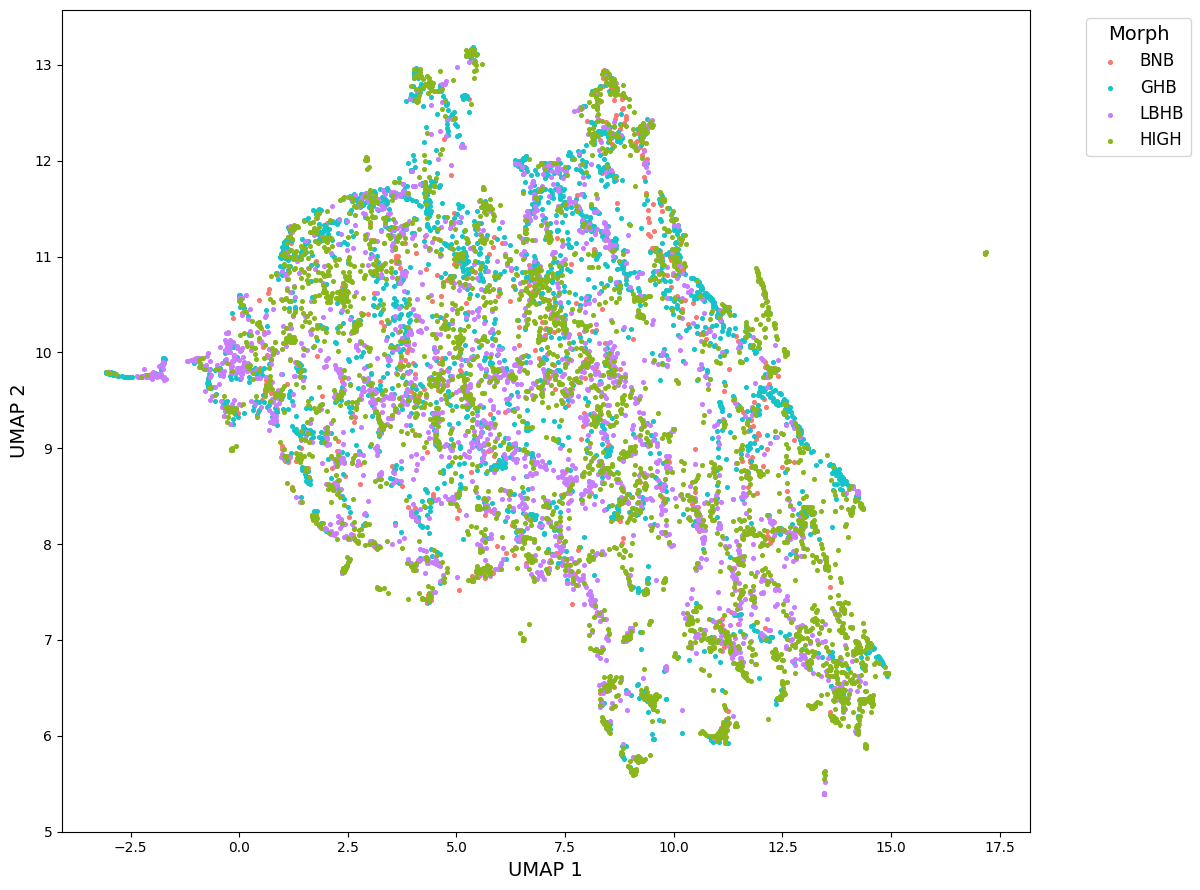

In [41]:
final_df['morph'] = final_df['morph'].astype('category')

unique_morphs = final_df['morph'].unique()
colors = ["#f8786f", "#15c4c8", "#c87eff", "#89b61b"]
color_map = dict(zip(unique_morphs, colors))

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

for morph, color in color_map.items():
    subset = final_df[final_df['morph'] == morph]
    plt.scatter(subset['UMAP 1'], subset['UMAP 2'], label=morph, color=color, alpha=1, s=7)

plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.show()

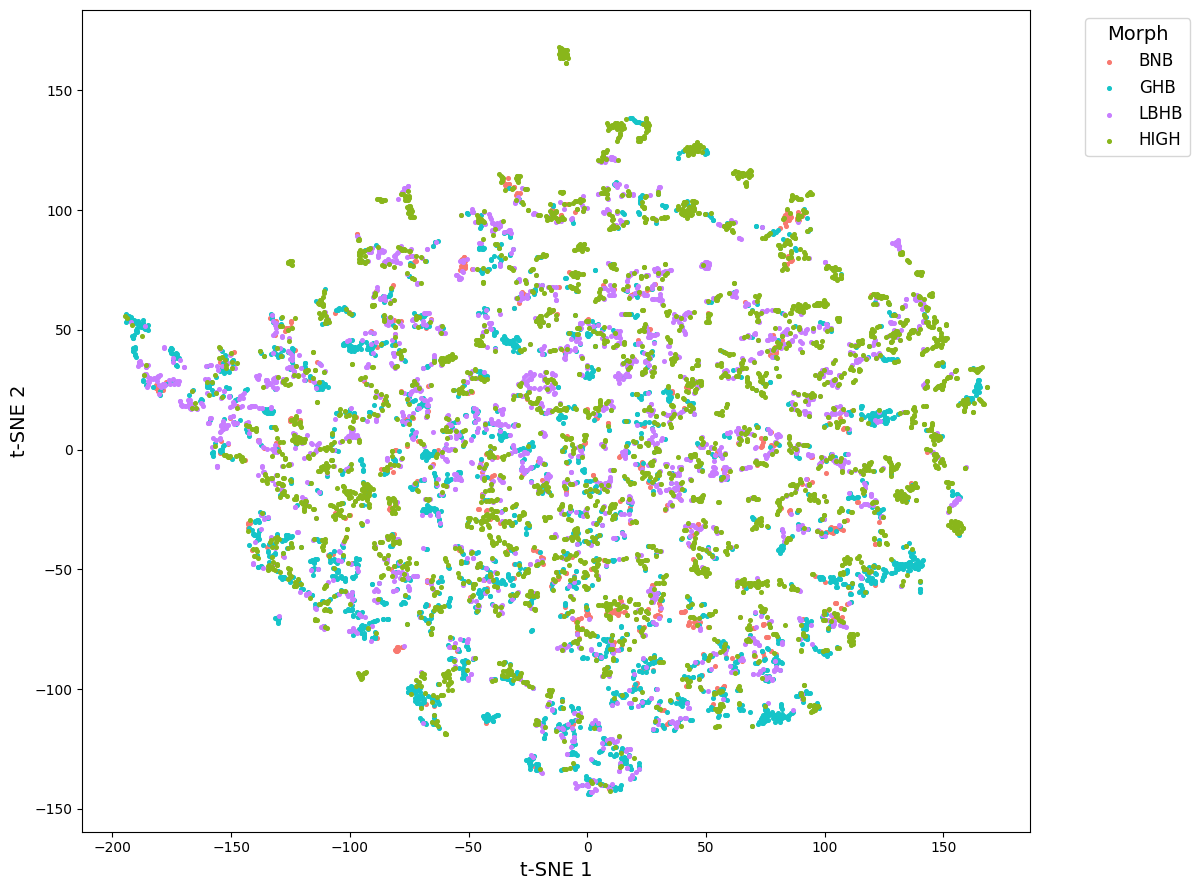

In [42]:
unique_morphs = final_df['morph'].unique()
colors = ["#f8786f", "#15c4c8", "#c87eff", "#89b61b"]
color_map = dict(zip(unique_morphs, colors))

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

for morph, color in color_map.items():
    subset = final_df[final_df['morph'] == morph]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=morph, color=color, alpha=1, s=7)

plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.show()

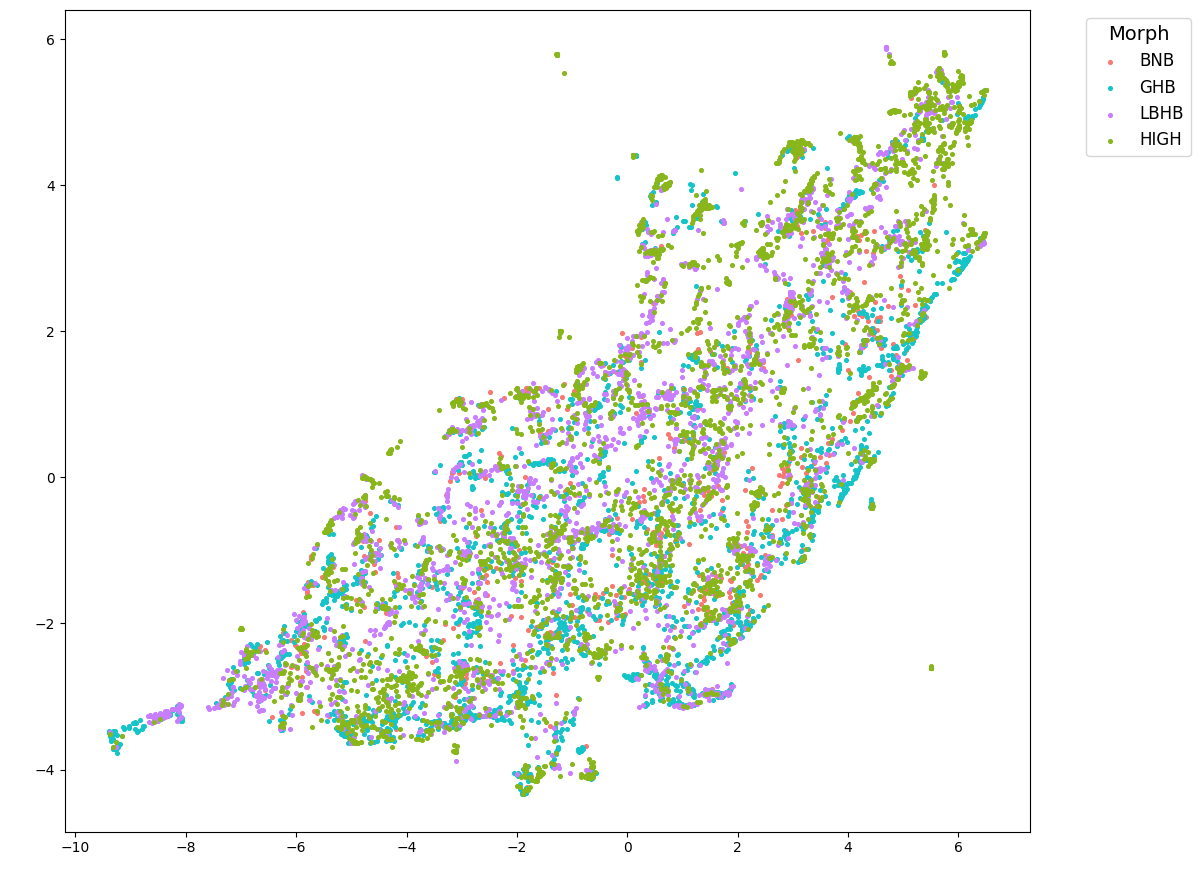

In [43]:
unique_morphs = final_df['morph'].unique()
colors = ["#f8786f", "#15c4c8", "#c87eff", "#89b61b"]
color_map = dict(zip(unique_morphs, colors))

# Create the plot
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

for morph, color in color_map.items():
    subset = final_df[final_df['morph'] == morph]
    plt.scatter(subset['UMAP 1 AVRG'], subset['UMAP 2 AVRG'], label=morph, color=color, alpha=1, s=7)

plt.xlabel('UMAP 1', fontsize=14, color='white')
plt.ylabel('UMAP 2', fontsize=14, color='white')
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()


plt.savefig('umap_avrg_contour.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

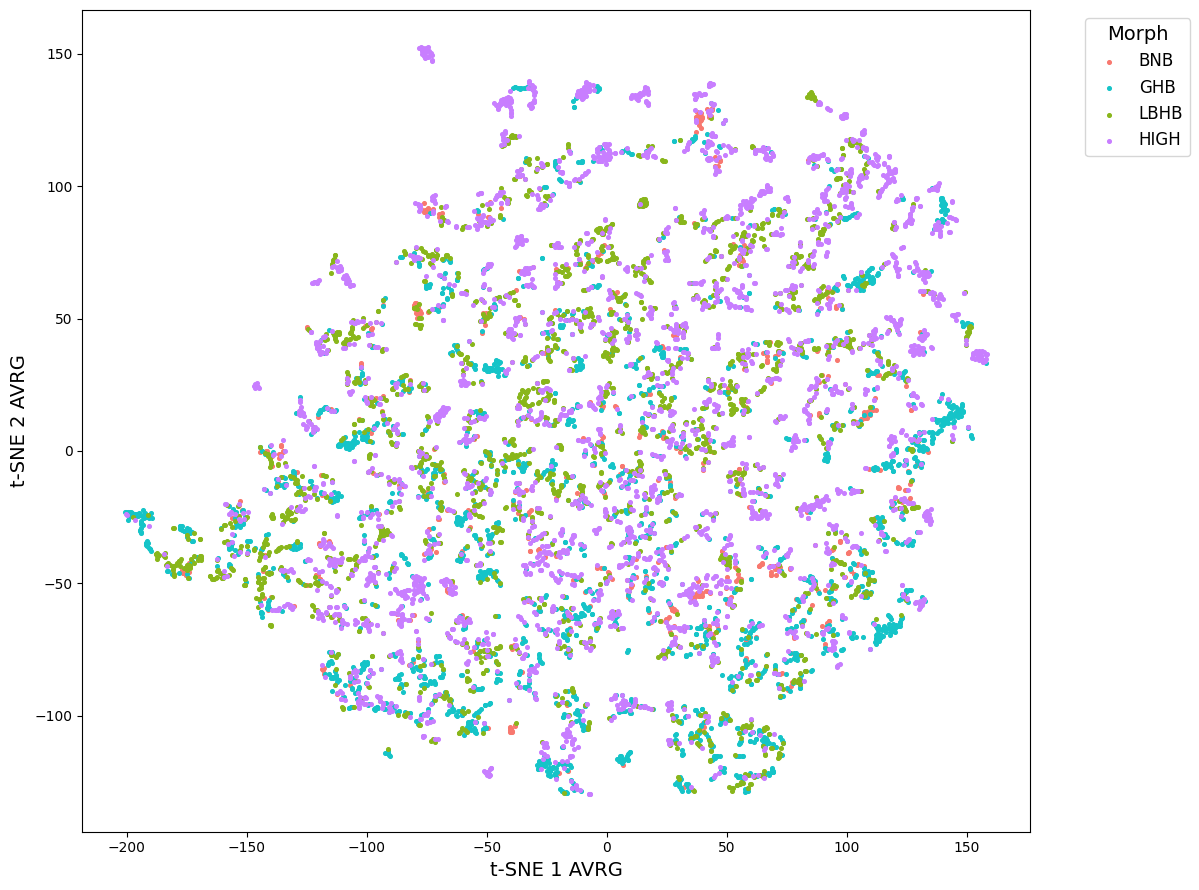

In [44]:
unique_morphs = final_df['morph'].unique()
colors = ["#f8786f", "#15c4c8", "#89b61b","#c87eff"]
color_map = dict(zip(unique_morphs, colors))

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

for morph, color in color_map.items():
    subset = final_df[final_df['morph'] == morph]
    plt.scatter(subset['t-SNE 1 AVRG'], subset['t-SNE 2 AVRG'], label=morph, color=color, alpha=1, s=7)

plt.xlabel('t-SNE 1 AVRG', fontsize=14)
plt.ylabel('t-SNE 2 AVRG', fontsize=14)
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.savefig('tsne_avrg_contour.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

final_df['prediction_correct'] = final_df['morph_predicted_sy_pcs'] == final_df['morph']

correct_classifications = final_df['prediction_correct'].sum()
total_classifications = final_df.shape[0]
percentage_correct = (correct_classifications / total_classifications) * 100

# Define the colors
correct_color = "#4d53eb"
incorrect_color = "#eb4d4d"  

# Create the plot
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

# Plot correct predictions
correct_subset = final_df[final_df['prediction_correct']]
plt.scatter(correct_subset['t-SNE 1 AVRG'], correct_subset['t-SNE 2 AVRG'],
            label='Correct', color=correct_color, alpha=1, s=7)

# Plot incorrect predictions
incorrect_subset = final_df[~final_df['prediction_correct']]
plt.scatter(incorrect_subset['t-SNE 1 AVRG'], incorrect_subset['t-SNE 2 AVRG'],
            label='Incorrect', color=incorrect_color, alpha=1, s=7)

plt.xlabel('t-SNE 1 AVRG', fontsize=14)
plt.ylabel('t-SNE 2 AVRG', fontsize=14)
plt.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.savefig('tsne_avrg_contour_rf_sy.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

print(f'Percentage of correct classifications: {percentage_correct:.2f}%')


final_df['prediction_correct'] = final_df['morph_predicted_bird_pcs'] == final_df['morph']

correct_classifications = final_df['prediction_correct'].sum()
total_classifications = final_df.shape[0]
percentage_correct = (correct_classifications / total_classifications) * 100

correct_color = "#4d53eb"
incorrect_color = "#eb4d4d"  

# Create the plot
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

# Plot correct predictions
correct_subset = final_df[final_df['prediction_correct']]
plt.scatter(correct_subset['t-SNE 1 AVRG'], correct_subset['t-SNE 2 AVRG'],
            label='Correct', color=correct_color, alpha=1, s=7)

# Plot incorrect predictions
incorrect_subset = final_df[~final_df['prediction_correct']]
plt.scatter(incorrect_subset['t-SNE 1 AVRG'], incorrect_subset['t-SNE 2 AVRG'],
            label='Incorrect', color=incorrect_color, alpha=1, s=7)

plt.xlabel('t-SNE 1 AVRG', fontsize=14)
plt.ylabel('t-SNE 2 AVRG', fontsize=14)
plt.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.savefig('tsne_avrg_contour_rf_bird.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

print(f'Percentage of correct classifications: {percentage_correct:.2f}%')

unique_morphs = final_df['morph'].unique()
colors = ["#f8786f", "#15c4c8", "#89b61b","#c87eff"]
color_map = dict(zip(unique_morphs, colors))

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

for morph, color in color_map.items():
    subset = final_df[final_df['morph'] == morph]
    plt.scatter(subset['t-SNE 1 AVRG'], subset['t-SNE 2 AVRG'], label=morph, color=color, alpha=1, s=7)

plt.xlabel('t-SNE 1 AVRG', fontsize=14)
plt.ylabel('t-SNE 2 AVRG', fontsize=14)
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.savefig('tsne_avrg_contour.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance

# Load data
pitch_contour_path = '/Users/quentinbacquele/Desktop/Internship/Berkeley/Reunion Gray white-eye/data/pitch_contour_dom4.csv'
pitch_contour_df = pd.read_csv(pitch_contour_path)

# Helper function to convert number to alphabetic representation
def number_to_letters(num):
    letters = ""
    while num >= 0:
        letters = chr(num % 26 + ord('A')) + letters
        num = num // 26 - 1
    return letters

unique_morphs = final_df['morph'].unique()
colors = ["#f8786f", "#15c4c8", "#89b61b","#c87eff"]
color_map = dict(zip(unique_morphs, colors))

fig, ax = plt.subplots(figsize=(12, 9))

# Main t-SNE scatter plot
for morph, color in color_map.items():
    subset = final_df[final_df['morph'] == morph]
    ax.scatter(subset['t-SNE 1 AVRG'], subset['t-SNE 2 AVRG'], label=morph, color=color, alpha=0.65, s=30)

plt.axis('off')  # Remove all axis elements
plt.subplots_adjust(right=0.75)

# Calculate centroid of the t-SNE cloud
centroid = np.array([final_df['t-SNE 1 AVRG'].mean(), final_df['t-SNE 2 AVRG'].mean()])

# Calculate radius of the t-SNE cloud
distances = final_df.apply(lambda row: distance.euclidean((row['t-SNE 1 AVRG'], row['t-SNE 2 AVRG']), centroid), axis=1)
radius = distances.max()

# Function to select points around a circle
def select_circular_points(subset, centroid, radius, factor, num_points):
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    selected_points = []
    for angle in angles:
        direction = np.array([np.cos(angle), np.sin(angle)])
        target_point = centroid + direction * radius * factor
        distances = subset.apply(lambda row: distance.euclidean((row['t-SNE 1 AVRG'], row['t-SNE 2 AVRG']), target_point), axis=1)
        closest_point = subset.loc[distances.idxmin()]
        selected_points.append(closest_point)
    return selected_points

# Select points around the center (1/4 of the radius) and the border (4/5 of the radius)
center_points = select_circular_points(final_df, centroid, radius, 0.25, num_points=4)
border_points = select_circular_points(final_df, centroid, radius, 0.8, num_points=4)
selected_points = center_points + border_points

# Ensure each set of four points contains one of each morph
def ensure_morphs(selected_points, morphs, centroid, radius, factor):
    morph_counts = {morph: 0 for morph in morphs}
    for point in selected_points:
        morph_counts[point['morph']] += 1
    
    for morph, count in morph_counts.items():
        if count == 0:
            subset = final_df[final_df['morph'] == morph]
            if len(subset) > 0:
                new_point = select_circular_points(subset, centroid, radius, factor, num_points=1)[0]
                selected_points.append(new_point)
    return selected_points

# Ensure morphs are represented
center_points = ensure_morphs(center_points, unique_morphs, centroid, radius, 0.25)[:4]
border_points = ensure_morphs(border_points, unique_morphs, centroid, radius, 0.8)[:4]
selected_points = center_points + border_points

# Mark the selected points with a cross and a number
for i, point in enumerate(selected_points):
    ax.scatter(point['t-SNE 1 AVRG'], point['t-SNE 2 AVRG'], color='black', marker='x', s=100)
    ax.text(point['t-SNE 1 AVRG'], point['t-SNE 2 AVRG'], str(i+1), color='black', fontsize=12, ha='right')

plt.tight_layout()
plt.savefig('tsne_with_numbers.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(4, 2, figsize=(16, 24))  # 8 subplots

for i, point in enumerate(selected_points):
    file_name = point['file_name']
    morph = point['morph']
    cluster = point['cluster']
    cluster_label = number_to_letters(cluster)
    syllable_data = pitch_contour_df[pitch_contour_df['file_name'] == file_name]
    pitch_order = syllable_data['pitch_order'].to_numpy()
    pitch_values = syllable_data['pitch_value'].to_numpy()
    adjusted_time = pitch_order  # Assuming pitch_order is in the correct time scale

    ax = axes[i // 2, i % 2]
    ax.plot(adjusted_time, pitch_values, color=color_map[morph], linewidth=5)
    ax.set_title(f"Line Plot {i+1} (Morph: {morph}, Cluster: {cluster_label})")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig('line_plots.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

k_range = range(2, 1001)
n_runs = 10
silhouette_scores = np.zeros((len(k_range), n_runs))

for run in range(n_runs):
    random_state = np.random.randint(1, 11)
    for i, k in enumerate(k_range):
        kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=1000)
        cluster_labels = kmeans.fit_predict(Xfinal)
        silhouette_avg = silhouette_score(Xfinal, cluster_labels)
        silhouette_scores[i, run] = silhouette_avg

# Calculate the average silhouette score for each k
average_silhouette_scores_umap_avrg = silhouette_scores.mean(axis=1)

# Function to find and print the maximum silhouette score within a given range
def print_max_silhouette_score(start, end, scores):
    max_value = max(scores[start:end])
    max_index = scores[start:end].argmax() + start + 2  # +2 to match the k values starting from 2
    print(f"Maximum silhouette score between {start + 2} and {end + 1} clusters: {max_value} (k={max_index})")

# Print maximum silhouette scores for the specified ranges
print_max_silhouette_score(0, 9, average_silhouette_scores_umap_avrg)
print_max_silhouette_score(9, 24, average_silhouette_scores_umap_avrg)
print_max_silhouette_score(24, 49, average_silhouette_scores_umap_avrg)
print_max_silhouette_score(49, 99, average_silhouette_scores_umap_avrg)
print_max_silhouette_score(99, 149, average_silhouette_scores_umap_avrg)
print_max_silhouette_score(149, 199, average_silhouette_scores_umap_avrg)

# Plotting the average silhouette scores against number of clusters
plt.figure(figsize=(10, 6))
plt.plot(k_range,average_silhouette_scores_umap_avrg, marker='o', linestyle='-')
plt.title('Average Silhouette Method For Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Average silhouette score')
plt.grid(False)
plt.savefig('silouhette_clusters.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()


Number of clusters: 125
Mean of samples per cluster: 72.952


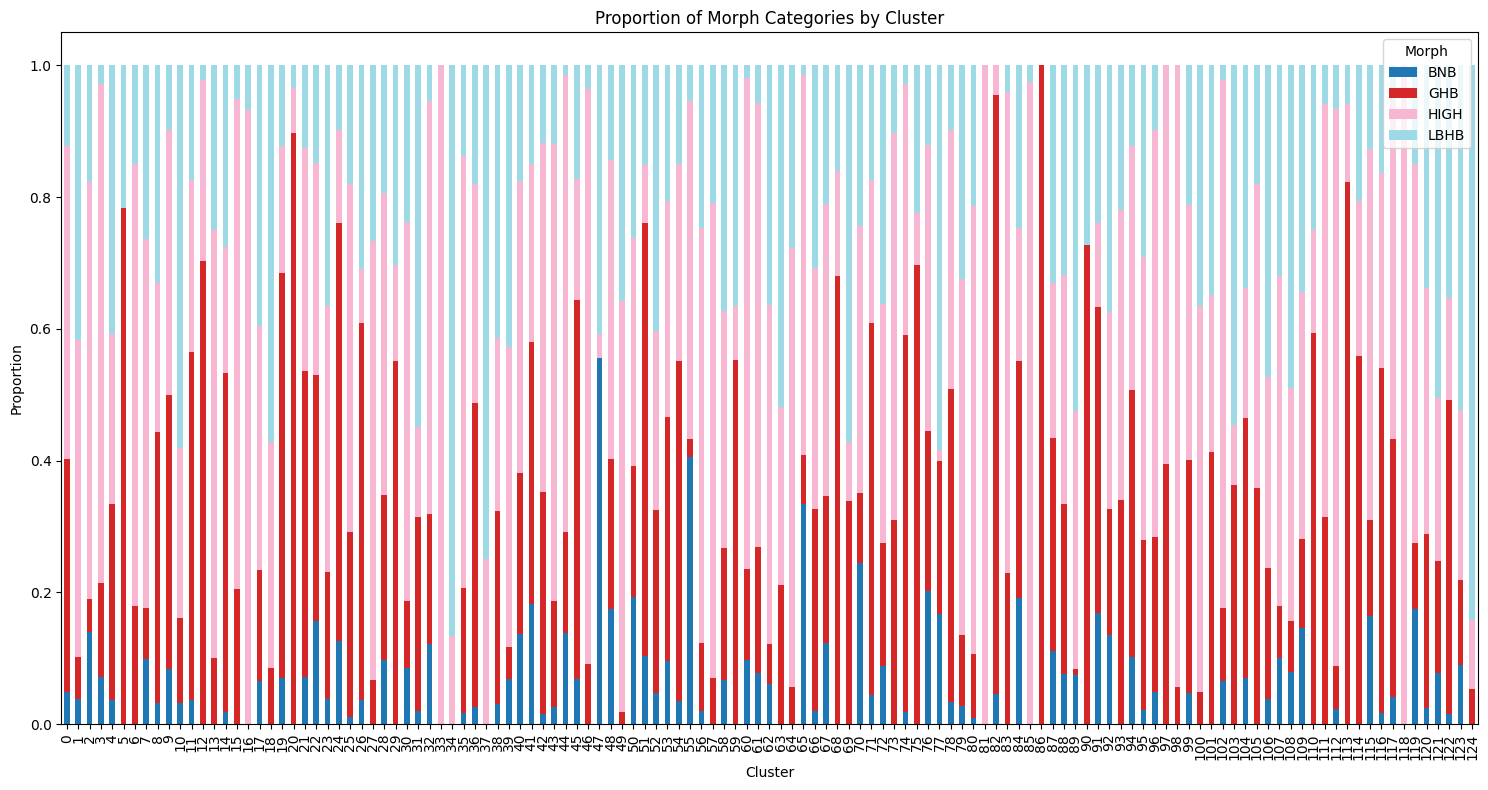

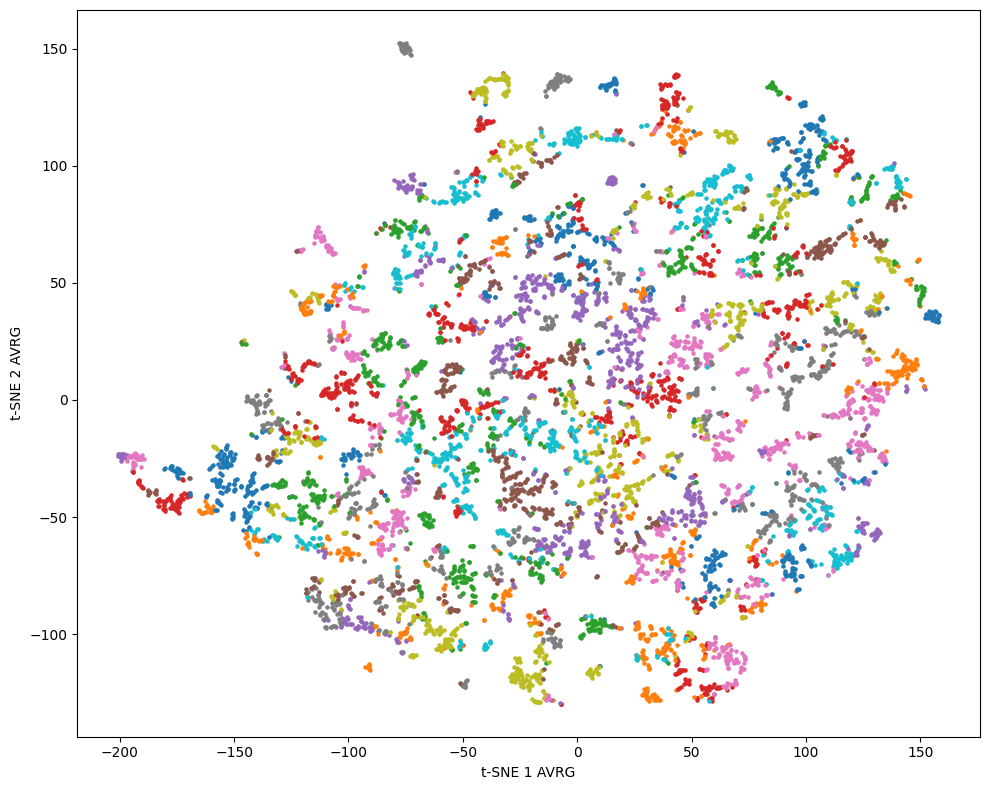

In [45]:

clusterer = KMeans(n_clusters=125, random_state=42, max_iter=1000) 
final_df['cluster'] = clusterer.fit_predict(Xfinal)

# Get the unique clusters
unique_clusters = final_df['cluster'].unique()

# Print the number of clusters (excluding noise if present)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
print(f'Number of clusters: {num_clusters}')

# Calculate and print the mean of samples by cluster
mean_samples_per_cluster = final_df[final_df['cluster'] != -1]['cluster'].value_counts().mean()
print(f'Mean of samples per cluster: {mean_samples_per_cluster}')

# Calculate and print the proportion of the categories of 'morph' by cluster
if 'morph' in final_df.columns:
    for cluster in unique_clusters:
        if cluster != -1:
            cluster_data = final_df[final_df['cluster'] == cluster]
            category_proportions = cluster_data['morph'].value_counts(normalize=True)

filtered_data = final_df[final_df['cluster'] != -1]

# Get the proportion of 'morph' categories by cluster
category_proportions = filtered_data.pivot_table(index='cluster', columns='morph', aggfunc='size', fill_value=0)
category_proportions = category_proportions.div(category_proportions.sum(axis=1), axis=0)  # Normalize to get proportions

# Plot the stacked bar chart
category_proportions.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab20')
plt.title('Proportion of Morph Categories by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Morph')
plt.tight_layout()


# Visualization code (unchanged)
palette = sns.color_palette("tab10", len(unique_clusters)-1 if -1 in unique_clusters else len(unique_clusters))
cluster_color_map = {cluster: (0, 0, 0) if cluster == -1 else color for cluster, color in zip(unique_clusters, palette)}

if -1 in unique_clusters:
    cluster_color_map[-1] = (0.85, 0.85, 0.85)

plt.figure(figsize=(10, 8))
for cluster, color in cluster_color_map.items():
    subset = final_df[final_df['cluster'] == cluster]
    plt.scatter(subset['t-SNE 1 AVRG'], subset['t-SNE 2 AVRG'], color=color, alpha=1, s=5, label=f'Cluster {cluster}')

plt.xlabel('t-SNE 1 AVRG')
plt.ylabel('t-SNE 2 AVRG')
plt.tight_layout()
plt.savefig('clusters_contour.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()


import string
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from itertools import product
from matplotlib.patches import Ellipse
import numpy as np


# Cluster assignment (assuming 'Xfinal' is your data to fit)
clusterer = KMeans(n_clusters=125, random_state=42, max_iter=1000) 
final_df['cluster'] = clusterer.fit_predict(Xfinal)

# Function to generate cluster names
def generate_cluster_names(n):
    alphabet = string.ascii_uppercase
    cluster_names = []
    length = 1
    while len(cluster_names) < n:
        cluster_names.extend([''.join(x) for x in product(alphabet, repeat=length)])
        length += 1
    return cluster_names[:n]

# Generate cluster names
num_clusters = final_df['cluster'].nunique()
cluster_names = generate_cluster_names(num_clusters)

# Create a mapping from original cluster numbers to new cluster names
cluster_mapping = {old: new for old, new in zip(sorted(final_df['cluster'].unique()), cluster_names)}
final_df['cluster_name'] = final_df['cluster'].map(cluster_mapping)

# Visualize the proportion of morph categories by cluster
filtered_data = final_df[final_df['cluster'] != -1]
category_proportions = filtered_data.pivot_table(index='cluster_name', columns='morph', aggfunc='size', fill_value=0)
category_proportions = category_proportions.div(category_proportions.sum(axis=1), axis=0)  # Normalize to get proportions

# Plot the stacked bar chart
category_proportions.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab20')
plt.title('Proportion of Morph Categories by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Morph')
plt.tight_layout()
plt.show()

# Visualization of t-SNE with specific clusters highlighted and ellipses
highlight_clusters = ['T', 'Z', 'CQ', 'BO', 'BH', 'DF', 'AW', 'CJ', 'DR', 'AQ']
color_palette = sns.color_palette("tab10", len(highlight_clusters))
color_map = {name: 'lightgrey' for name in cluster_names}
color_map.update({name: color for name, color in zip(highlight_clusters, color_palette)})

plt.figure(figsize=(10, 8))

# Plot lightgrey clusters first
for cluster_name, color in color_map.items():
    if color == 'lightgrey':
        subset = final_df[final_df['cluster_name'] == cluster_name]
        plt.scatter(subset['t-SNE 1 AVRG'], subset['t-SNE 2 AVRG'], color=color, alpha=1, s=5)

# Plot highlighted clusters on top
for cluster_name, color in color_map.items():
    if color != 'lightgrey':
        subset = final_df[final_df['cluster_name'] == cluster_name]
        plt.scatter(subset['t-SNE 1 AVRG'], subset['t-SNE 2 AVRG'], color=color, alpha=1, s=5, label=cluster_name)
        
        # Calculate the ellipse parameters
        mean_x, mean_y = subset['t-SNE 1 AVRG'].mean(), subset['t-SNE 2 AVRG'].mean()
        cov = np.cov(subset['t-SNE 1 AVRG'], subset['t-SNE 2 AVRG'])
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

        # Width and height are "2.5 standard deviations" to increase the size slightly
        width, height = 2.5 * np.sqrt(eigenvalues)
        ellipse = Ellipse((mean_x, mean_y), width, height, angle=angle, edgecolor=color, facecolor=color, alpha=0.2, linewidth=2)
        plt.gca().add_patch(ellipse)

plt.xlabel('t-SNE 1 AVRG')
plt.ylabel('t-SNE 2 AVRG')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('clusters_contour.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()


Number of clusters: 125
Mean of samples per cluster: 72.952


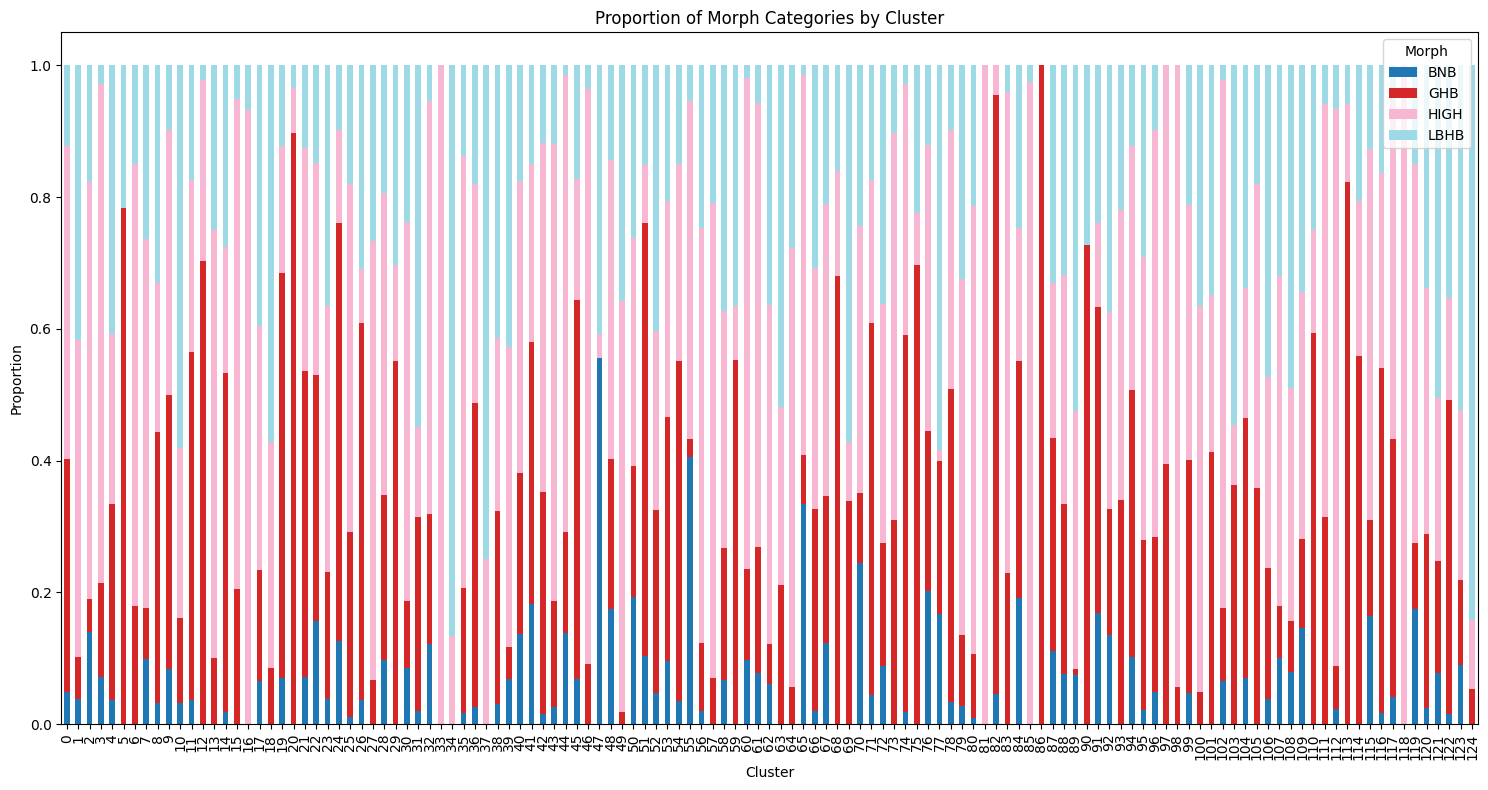

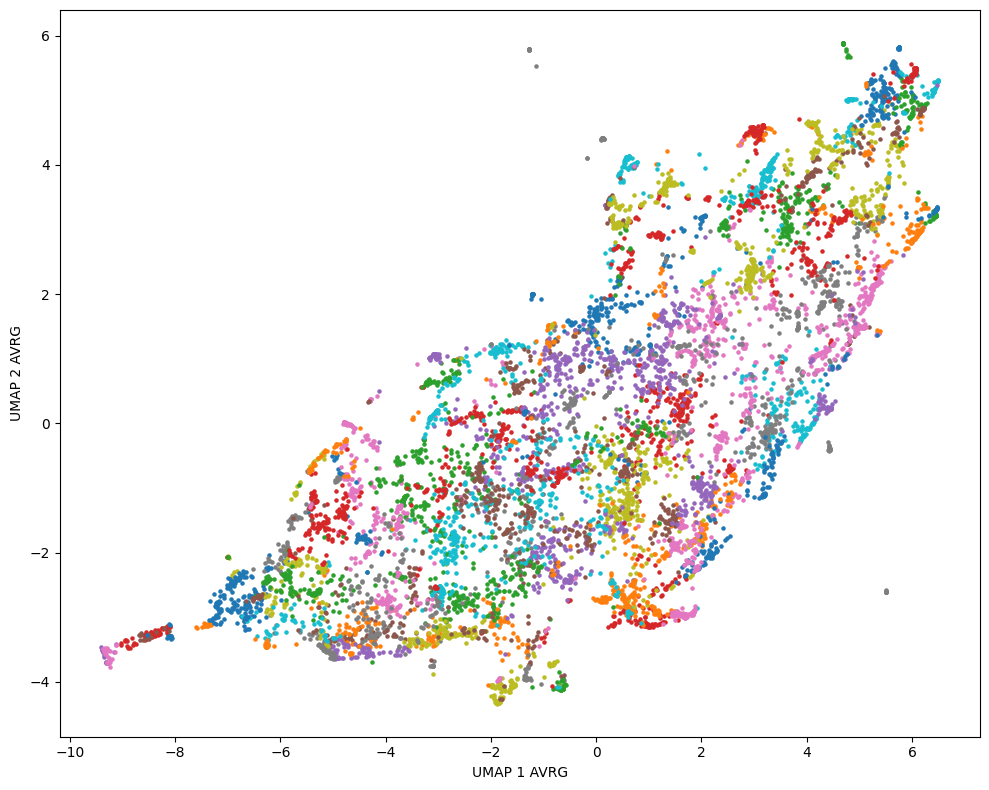

In [46]:

clusterer = KMeans(n_clusters=125, random_state=42, max_iter=1000) 
final_df['cluster'] = clusterer.fit_predict(Xfinal)

# Get the unique clusters
unique_clusters = final_df['cluster'].unique()

# Print the number of clusters (excluding noise if present)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
print(f'Number of clusters: {num_clusters}')

# Calculate and print the mean of samples by cluster
mean_samples_per_cluster = final_df[final_df['cluster'] != -1]['cluster'].value_counts().mean()
print(f'Mean of samples per cluster: {mean_samples_per_cluster}')

# Calculate and print the proportion of the categories of 'morph' by cluster
if 'morph' in final_df.columns:
    for cluster in unique_clusters:
        if cluster != -1:
            cluster_data = final_df[final_df['cluster'] == cluster]
            category_proportions = cluster_data['morph'].value_counts(normalize=True)

filtered_data = final_df[final_df['cluster'] != -1]

# Get the proportion of 'morph' categories by cluster
category_proportions = filtered_data.pivot_table(index='cluster', columns='morph', aggfunc='size', fill_value=0)
category_proportions = category_proportions.div(category_proportions.sum(axis=1), axis=0)  # Normalize to get proportions

# Plot the stacked bar chart
category_proportions.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab20')
plt.title('Proportion of Morph Categories by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Morph')
plt.tight_layout()


# Visualization code (unchanged)
palette = sns.color_palette("tab10", len(unique_clusters)-1 if -1 in unique_clusters else len(unique_clusters))
cluster_color_map = {cluster: (0, 0, 0) if cluster == -1 else color for cluster, color in zip(unique_clusters, palette)}

if -1 in unique_clusters:
    cluster_color_map[-1] = (0.85, 0.85, 0.85)

plt.figure(figsize=(10, 8))
for cluster, color in cluster_color_map.items():
    subset = final_df[final_df['cluster'] == cluster]
    plt.scatter(subset['UMAP 1 AVRG'], subset['UMAP 2 AVRG'], color=color, alpha=1, s=5, label=f'Cluster {cluster}')

plt.xlabel('UMAP 1 AVRG')
plt.ylabel('UMAP 2 AVRG')
plt.tight_layout()
plt.show()


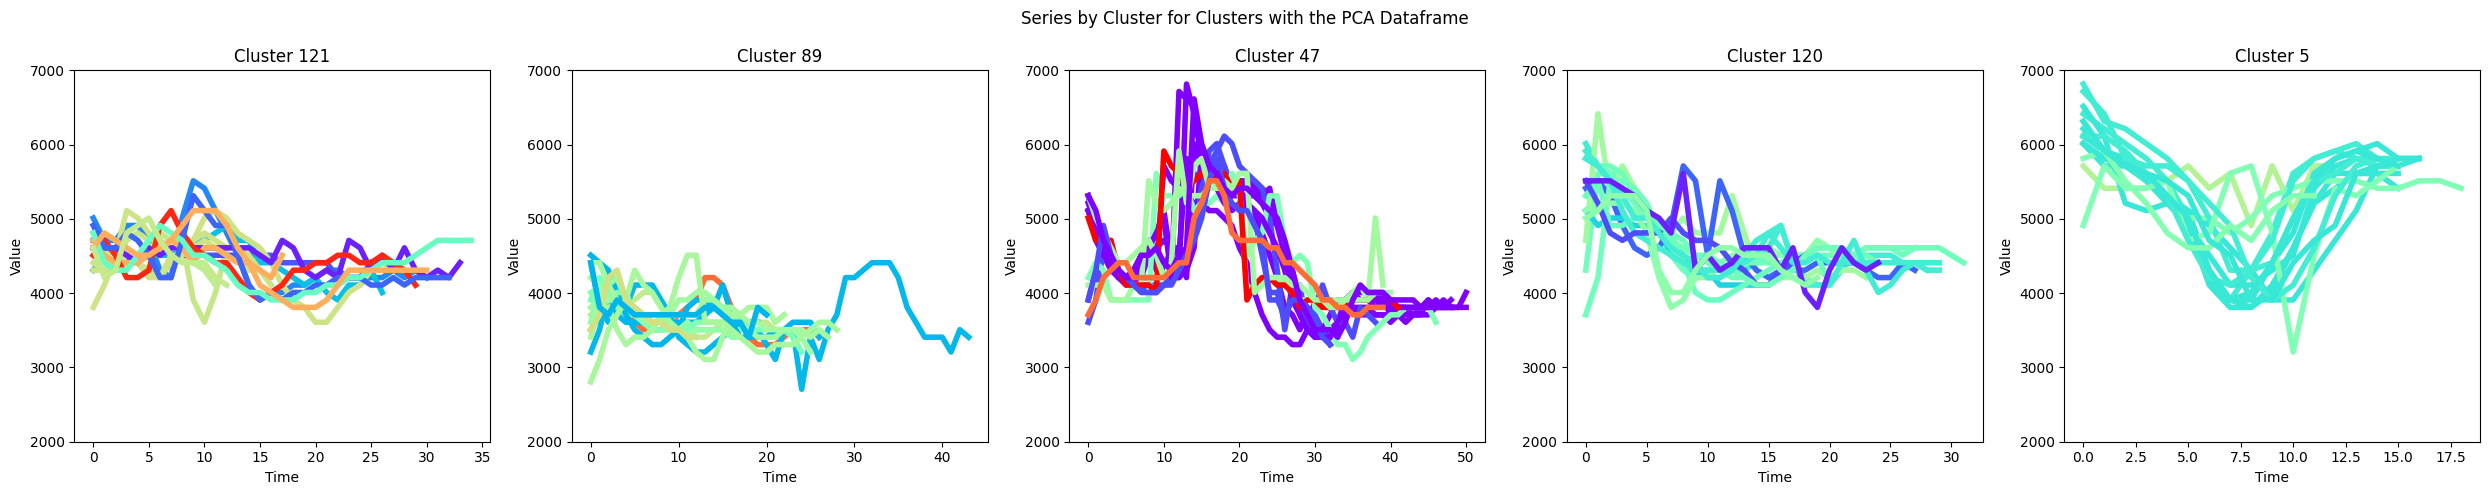

In [47]:
kmeans_clusterer = KMeans(n_clusters=125, random_state=42) 
final_df['cluster'] = kmeans_clusterer.fit_predict(Xfinal)

data_contour = pd.read_csv('data/pitch_contour_dom.csv')
data_contour = pd.merge(final_df, data_contour, on='file_name', how='left')

def get_series(df):
    series_list = []
    names_list = []
    current_series = []
    previous_order = -1
    for _, row in df.iterrows():
        if row['pitch_order'] == 0 and previous_order != -1:
            series_list.append(current_series)
            names_list.append(f"{row['file_name']} ({row['cluster']})")
            current_series = []
        current_series.append(row['pitch_value'])
        previous_order = row['pitch_order']
    if current_series:  # Add the last series if exists
        series_list.append(current_series)
        names_list.append(f"{row['file_name']} ({row['cluster']})")
    return series_list, names_list


def plot_clusters(data_contour, clustering_label, title_prefix):
    # Get unique birds and assign colors
    unique_birds = data_contour['bird_y'].unique()
    bird_color_map = {bird: color for bird, color in zip(unique_birds, plt.cm.rainbow(np.linspace(0, 1, len(unique_birds))))}

    clusters = data_contour[clustering_label].unique()
    selected_clusters = np.random.choice(clusters, size=5, replace=False)

    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(f'Series by Cluster for {title_prefix}')

    for i, cluster in enumerate(selected_clusters):
        cluster_df = data_contour[data_contour[clustering_label] == cluster]
        unique_files = cluster_df['file_name'].unique()
        selected_files = np.random.choice(unique_files, size=min(15, len(unique_files)), replace=False)

        for file_name in selected_files:
            file_df = cluster_df[cluster_df['file_name'] == file_name]
            series, _ = get_series(file_df)
            bird = file_df['bird_y'].iloc[0]  # assuming all rows in file_df have the same bird value

            for series_data in series:
                axs[i].plot(series_data, linewidth=4, color=bird_color_map[bird])
        
        axs[i].set_title(f'Cluster {cluster}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Value')
        axs[i].set_ylim(2000, 7000)

    plt.tight_layout()
    plt.show()
    
plot_clusters(data_contour, 'cluster', 'Clusters with the PCA Dataframe')


wide_df['cluster'] = final_df['cluster']

cluster_label = 40
selected_indices = wide_df[wide_df['cluster'] == cluster_label].index

# Extract the corresponding rows from the data matrix
data_matrix = wide_df[[i for i in range(1, 81)]].values

# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i, :]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

# Select top k eigenvectors
top_k = 5
eig_vecs_sorted = eig_vecs_sorted[:top_k, :]

# Compute principal components for the entire data matrix
principal_components = data_matrix @ eig_vecs_sorted.T

# Compute the mean of the principal components for the selected indices
mean_principal_components = np.mean(principal_components[selected_indices], axis=0)

# Reconstruct the data from the mean principal components
mean_reconstructed_data = np.dot(mean_principal_components, eig_vecs_sorted)

# Compute the mean of the 85th column of the selected rows
mean_wide_df = np.mean(wide_df.iloc[selected_indices, 85])

# Add the mean of the 85th column to the reconstructed data
first_time_series_reconstructed = mean_reconstructed_data + mean_wide_df

# Convert the index to time in seconds
num_points = first_time_series_reconstructed.shape[0]
time = np.arange(num_points) * window_size / Fs

# Plot the reconstructed average time series with time on the x-axis
plt.figure(figsize=(7, 4))
plt.plot(time, first_time_series_reconstructed, label='Reconstructed Average Time Series', color='red', linewidth=4)
plt.ylim(3000, 5500)
plt.xticks([0, 0.1], ['0', '0.1'],fontsize=26)
plt.yticks([3000, 4000, 5000], ['3', '4', '5'],fontsize=26)
plt.savefig('average_BO.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [48]:
final_df['syllable'] = final_df['file_name']
final_df['file_name'] = final_df['file_name'].str.split('_', n=1).str[1]
filtered_data = final_df[final_df['cluster'] != -1][['file_name', 'bird', 'cluster']]
pivot_table = filtered_data.pivot_table(index=['file_name', 'bird'], columns='cluster', aggfunc=len, fill_value=0)
normalized_pivot = pivot_table.div(pivot_table.sum(axis=1), axis=0)
bird_mean = normalized_pivot.groupby('bird').mean()

distance_matrix = pairwise_distances(bird_mean, metric='euclidean')
birds = bird_mean.index
distance_df_euc = pd.DataFrame(distance_matrix, index=birds, columns=birds)
distance_df_euc

bird          ZB_0001   ZB_0002       ZB_0003   ZB_0004       ZB_0005  \
bird                                                                    
ZB_0001  7.450581e-09  0.326791  3.307368e-01  0.318321  3.422383e-01   
ZB_0002  3.267907e-01  0.000000  4.175675e-01  0.361022  4.278448e-01   
ZB_0003  3.307368e-01  0.417567  5.268356e-09  0.326018  3.307301e-01   
ZB_0004  3.183211e-01  0.361022  3.260176e-01  0.000000  3.275130e-01   
ZB_0005  3.422383e-01  0.427845  3.307301e-01  0.327513  5.268356e-09   
...               ...       ...           ...       ...           ...   
ZB_0094  2.987917e-01  0.397637  3.030253e-01  0.301630  2.913037e-01   
ZB_0095  2.655811e-01  0.360509  2.870169e-01  0.263648  2.786622e-01   
ZB_0096  3.170641e-01  0.391446  3.398816e-01  0.274454  3.084712e-01   
ZB_0097  3.098195e-01  0.367120  3.085694e-01  0.258524  2.716096e-01   
ZB_0098  3.422905e-01  0.434719  3.520046e-01  0.340523  3.205173e-01   

bird      ZB_0006   ZB_0007   ZB_0008   ZB_0009   ZB_0010  ...   ZB_0089  \
bird                                                       ...             
ZB_0001  0.300510  0.389983  0.327783  0.269225  0.312512  ...  0.302039   
ZB_0002  0.352150  0.453624  0.419067  0.353463  0.403345  ...  0.380325   
ZB_0003  0.295459  0.335920  0.358979  0.316042  0.352053  ...  0.312794   
ZB_0004  0.299973  0.359866  0.307616  0.285030  0.293519  ...  0.287882   
ZB_0005  0.287477  0.361495  0.330146  0.298462  0.301305  ...  0.265749   
...           ...       ...       ...       ...       ...  ...       ...   
ZB_0094  0.261487  0.337828  0.327812  0.241425  0.243135  ...  0.210404   
ZB_0095  0.216260  0.318867  0.304531  0.215790  0.229586  ...  0.196228   
ZB_0096  0.253085  0.339133  0.324999  0.273410  0.256406  ...  0.217087   
ZB_0097  0.239695  0.325147  0.322095  0.267421  0.269004  ...  0.213734   
ZB_0098  0.303284  0.391449  0.367421  0.308428  0.239040  ...  0.235651   

bird      ZB_0090   ZB_0091   ZB_0092   ZB_0093   ZB_0094       ZB_0095  \
bird                                                                      
ZB_0001  0.306268  0.300194  0.323361  0.294089  0.298792  2.655811e-01   
ZB_0002  0.397145  0.361493  0.405508  0.366834  0.397637  3.605090e-01   
ZB_0003  0.303084  0.293253  0.280162  0.296161  0.303025  2.870169e-01   
ZB_0004  0.285712  0.286195  0.325822  0.275599  0.301630  2.636484e-01   
ZB_0005  0.269252  0.282031  0.300169  0.262928  0.291304  2.786622e-01   
...           ...       ...       ...       ...       ...           ...   
ZB_0094  0.246349  0.241761  0.257198  0.231881  0.000000  1.923922e-01   
ZB_0095  0.230091  0.218612  0.245346  0.215472  0.192392  5.268356e-09   
ZB_0096  0.242929  0.252981  0.274492  0.245318  0.226776  2.144557e-01   
ZB_0097  0.206359  0.225622  0.218794  0.221610  0.230375  2.052562e-01   
ZB_0098  0.304578  0.298750  0.340330  0.281943  0.255414  2.542670e-01   

bird          ZB_0096       ZB_0097   ZB_0098  
bird                                           
ZB_0001  3.170641e-01  3.098195e-01  0.342291  
ZB_0002  3.914461e-01  3.671205e-01  0.434719  
ZB_0003  3.398816e-01  3.085694e-01  0.352005  
ZB_0004  2.744536e-01  2.585240e-01  0.340523  
ZB_0005  3.084712e-01  2.716096e-01  0.320517  
...               ...           ...       ...  
ZB_0094  2.267758e-01  2.303751e-01  0.255414  
ZB_0095  2.144557e-01  2.052562e-01  0.254267  
ZB_0096  5.268356e-09  2.025031e-01  0.265839  
ZB_0097  2.025031e-01  3.725290e-09  0.295054  
ZB_0098  2.658385e-01  2.950538e-01  0.000000  

[98 rows x 98 columns]

In [49]:
bird_morph_df = final_df[['bird', 'morph']].drop_duplicates()
normalized_pivot_reset = bird_mean.reset_index()
prop_sy_df = normalized_pivot_reset.merge(bird_morph_df, on='bird', how='left')
prop_sy_df = prop_sy_df.set_index('bird')

Average Accuracy: 0.4896
Average Recall: 0.4896
Average Precision: 0.4785


/var/folders/12/ks7q36dj491dw0thmdw9zz_40000gn/T/ipykernel_5610/333637294.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(morph_labels))
/var/folders/12/ks7q36dj491dw0thmdw9zz_40000gn/T/ipykernel_5610/333637294.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(morph_labels))


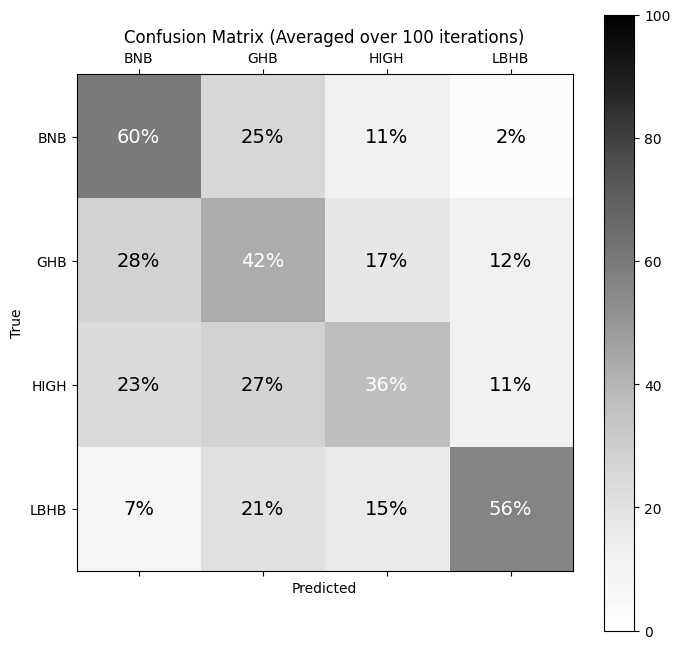

In [50]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming prop_sy_df is the DataFrame with normalized data and 'morph' column

# Split the data into train and test based on unique birds
birds = np.unique(prop_sy_df.index)
train_birds, test_birds = train_test_split(birds, test_size=0.2, random_state=42)

train_idx = prop_sy_df.index.isin(train_birds)
test_idx = prop_sy_df.index.isin(test_birds)

# Define features and target
features = prop_sy_df.drop(columns=['morph'])
target = 'morph'

X_train = features.loc[train_idx].values
y_train = prop_sy_df.loc[train_idx, target].values
X_test = features.loc[test_idx].values
y_test = prop_sy_df.loc[test_idx, target].values

# Classifier
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

# Initialize metrics
n_iterations = 100
accuracies, recalls, precisions = [], [], []
conf_matrix_sum = None

# Run the model multiple times
for iteration in range(n_iterations):
    # Analyze class distribution and resample
    class_labels, counts = np.unique(y_train, return_counts=True)
    min_samples = np.min(counts)

    X_resampled = []
    y_resampled = []

    for label in class_labels:
        idx = np.where(y_train == label)[0]
        resampled_idx = np.random.choice(idx, min_samples, replace=False)
        X_resampled.append(X_train[resampled_idx])
        y_resampled.append(y_train[resampled_idx])

    X_resampled = np.concatenate(X_resampled)
    y_resampled = np.concatenate(y_resampled)

    # Stratified K-Fold on the resampled data
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, test_idx in cv.split(X_resampled, y_resampled):
        X_train_fold, X_test_fold = X_resampled[train_idx], X_resampled[test_idx]
        y_train_fold, y_test_fold = y_resampled[train_idx], y_resampled[test_idx]

        rf_clf.fit(X_train_fold, y_train_fold)
        y_pred_fold = rf_clf.predict(X_test_fold)

        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
        recalls.append(recall_score(y_test_fold, y_pred_fold, average='weighted', zero_division=0))
        precisions.append(precision_score(y_test_fold, y_pred_fold, average='weighted', zero_division=0))
        
        conf_matrix = confusion_matrix(y_test_fold, y_pred_fold)
        if conf_matrix_sum is None:
            conf_matrix_sum = conf_matrix
        else:
            conf_matrix_sum += conf_matrix

# Compute average metrics
average_accuracy = np.mean(accuracies)
average_recall = np.mean(recalls)
average_precision = np.mean(precisions)

# Display results
print(f'Average Accuracy: {average_accuracy:.4f}')
print(f'Average Recall: {average_recall:.4f}')
print(f'Average Precision: {average_precision:.4f}')

morph_labels = prop_sy_df['morph'].unique()
morph_labels = np.sort(morph_labels)  # Ensure the labels are in the correct order

# Visualize the averaged confusion matrix
conf_matrix_percentage = conf_matrix_sum.astype('float') / conf_matrix_sum.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(conf_matrix_percentage, cmap=plt.cm.Greys, vmin=0, vmax=100)
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Averaged over 100 iterations)')

# Set x and y labels with morph names
ax.set_xticklabels([''] + list(morph_labels))
ax.set_yticklabels([''] + list(morph_labels))

thresh = conf_matrix_percentage.max() / 2.
for i in range(conf_matrix_percentage.shape[0]):
    for j in range(conf_matrix_percentage.shape[1]):
        text = f"{int(conf_matrix_percentage[i, j])}%"  # Format as whole number percentage
        ax.text(j, i, text, ha='center', va='center', fontsize=14, color="white" if conf_matrix_percentage[i, j] > thresh else "black")

plt.savefig('conf_mat_rf_contour_syllables.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()


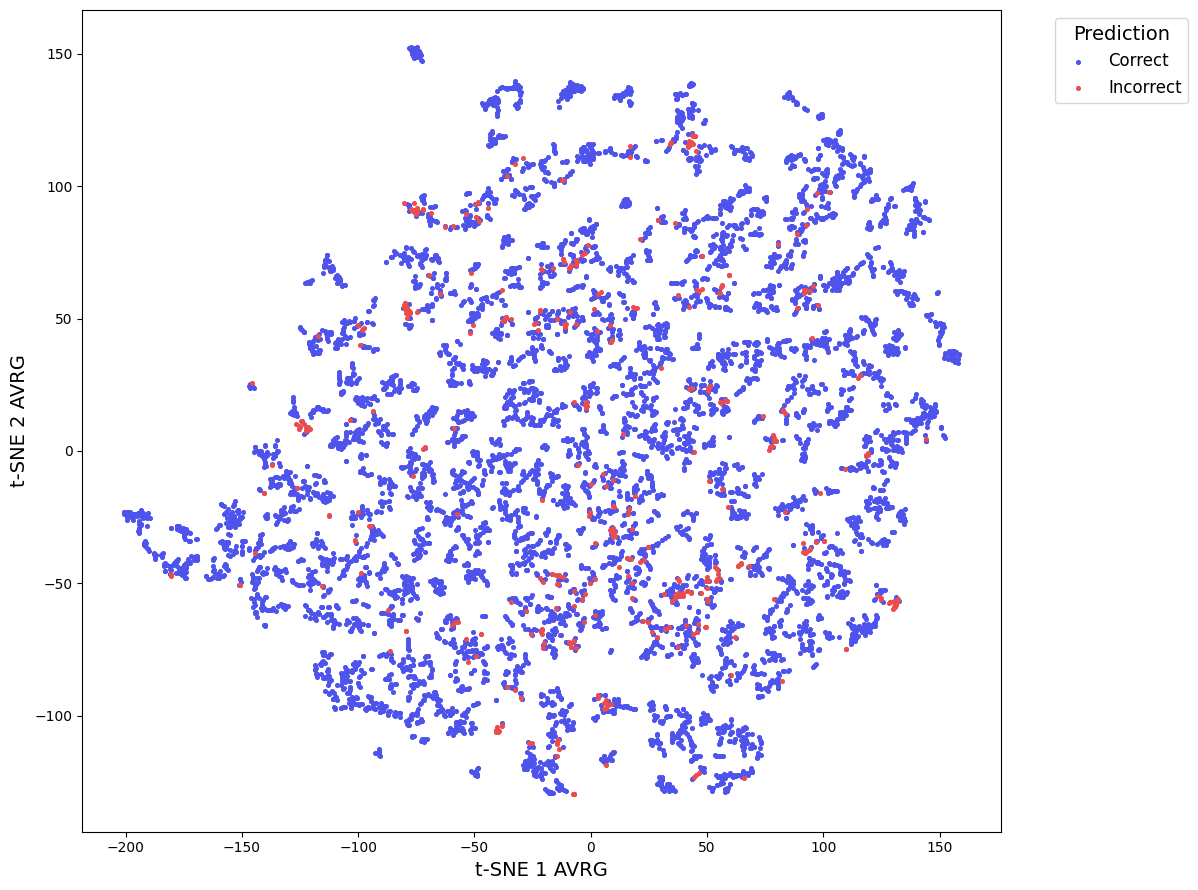

Percentage of correct classifications: 95.43%


In [51]:
birds = np.unique(prop_sy_df.index)
train_birds, test_birds = train_test_split(birds, test_size=0.2, random_state=42)

train_idx = prop_sy_df.index.isin(train_birds)
test_idx = prop_sy_df.index.isin(test_birds)

# Define features and target
features = prop_sy_df.iloc[:, 1:125]
target = 'morph'

X_train = features.loc[train_idx].values
y_train = prop_sy_df.loc[train_idx, target].values
X_test = features.loc[test_idx].values
y_test = prop_sy_df.loc[test_idx, target].values

# Classifier
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

# Initialize storage for probabilities
probabilities_list = []

# Number of iterations
n_iterations = 100

# Run the model multiple times
for iteration in range(n_iterations):
    # Analyze class distribution and resample
    class_labels, counts = np.unique(y_train, return_counts=True)
    min_samples = np.min(counts)

    X_resampled = []
    y_resampled = []

    for label in class_labels:
        idx = np.where(y_train == label)[0]
        resampled_idx = np.random.choice(idx, min_samples, replace=False)
        X_resampled.append(X_train[resampled_idx])
        y_resampled.append(y_train[resampled_idx])

    X_resampled = np.concatenate(X_resampled)
    y_resampled = np.concatenate(y_resampled)

    # Fit the classifier on the resampled data
    rf_clf.fit(X_resampled, y_resampled)

    # Obtain predicted probabilities for all samples
    probabilities = rf_clf.predict_proba(features.values)
    probabilities_list.append(probabilities)

mean_probabilities = np.mean(probabilities_list, axis=0)

# Create a DataFrame to store the mean probabilities for each bird
bird_mean_prob_df = pd.DataFrame(mean_probabilities, index=features.index, columns=rf_clf.classes_)

# Add column for predicted morphs based on highest mean probability
bird_mean_prob_df['morph_predicted_birds_sg'] = rf_clf.classes_[np.argmax(mean_probabilities, axis=1)]

# Create a mapping from bird to predicted morph
bird_to_predicted_morph = bird_mean_prob_df['morph_predicted_birds_sg'].to_dict()

# Add the predicted morphs to the final_df based on bird name
final_df['morph_predicted_birds_sg'] = final_df['bird'].map(bird_to_predicted_morph)

# Create a new column to indicate if the prediction is correct or not
final_df['prediction_correct'] = final_df['morph_predicted_birds_sg'] == final_df['morph']


correct_classifications = final_df['prediction_correct'].sum()
total_classifications = final_df.shape[0]
percentage_correct = (correct_classifications / total_classifications) * 100

correct_color = "#4d53eb"
incorrect_color = "#eb4d4d"  

# Create the plot
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

# Plot correct predictions
correct_subset = final_df[final_df['prediction_correct']]
plt.scatter(correct_subset['t-SNE 1 AVRG'], correct_subset['t-SNE 2 AVRG'],
            label='Correct', color=correct_color, alpha=1, s=7)

# Plot incorrect predictions
incorrect_subset = final_df[~final_df['prediction_correct']]
plt.scatter(incorrect_subset['t-SNE 1 AVRG'], incorrect_subset['t-SNE 2 AVRG'],
            label='Incorrect', color=incorrect_color, alpha=1, s=7)

plt.xlabel('t-SNE 1 AVRG', fontsize=14)
plt.ylabel('t-SNE 2 AVRG', fontsize=14)
plt.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.savefig('tsne_avrg_rf_sg_bird.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

print(f'Percentage of correct classifications: {percentage_correct:.2f}%')


In [ ]:
bird_prob_copy = bird_mean_prob_df.copy()
bird_prob_copy = bird_prob_copy.reset_index()
bird_prob_copy = bird_prob_copy.rename(columns={'index': 'bird'})

tsne_post_df = pd.merge(bird_prob_copy, final_df[['bird', 'morph']], on='bird', how='left')
tsne_post_df.drop_duplicates(inplace=True)

X_post = prop_sy_df.iloc[:,0:125]

tsne_post = TSNE(n_components=2, perplexity=50, random_state=42, n_iter=10000)  
X_tsne_post = tsne_post.fit_transform(X_post)

tsne_post_df['t-SNE 1 post'] = X_tsne_post[:, 0]
tsne_post_df['t-SNE 2 post'] = X_tsne_post[:, 1]

unique_morphs = tsne_post_df['morph'].unique()
colors = ["#f8786f", "#15c4c8", "#89b61b", "#c87eff"]
color_map = dict(zip(unique_morphs, colors))

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)

for morph, color in color_map.items():
    subset = tsne_post_df[final_df['morph'] == morph]
    plt.scatter(subset['t-SNE 1 post'], subset['t-SNE 2 post'], label=morph, color=color, alpha=1, s=20)

plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.savefig('tsne_posteriors.png', dpi=600, edgecolor='none', bbox_inches='tight')
plt.show()

In [119]:
#bird_mean_prob_df.drop(columns='morph_predicted_birds_sg', inplace=True)
bird_mean_prob_array = bird_mean_prob_df.values

In [120]:
distance_matrix = pdist(bird_mean_prob_array, metric='euclidean')

# Create a DataFrame for the distance matrix
distance_df = pd.DataFrame(
    squareform(distance_matrix),
    index=bird_mean_prob_df.index,
    columns=bird_mean_prob_df.index
)

/var/folders/12/ks7q36dj491dw0thmdw9zz_40000gn/T/ipykernel_52749/1430738417.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_df, method='complete')


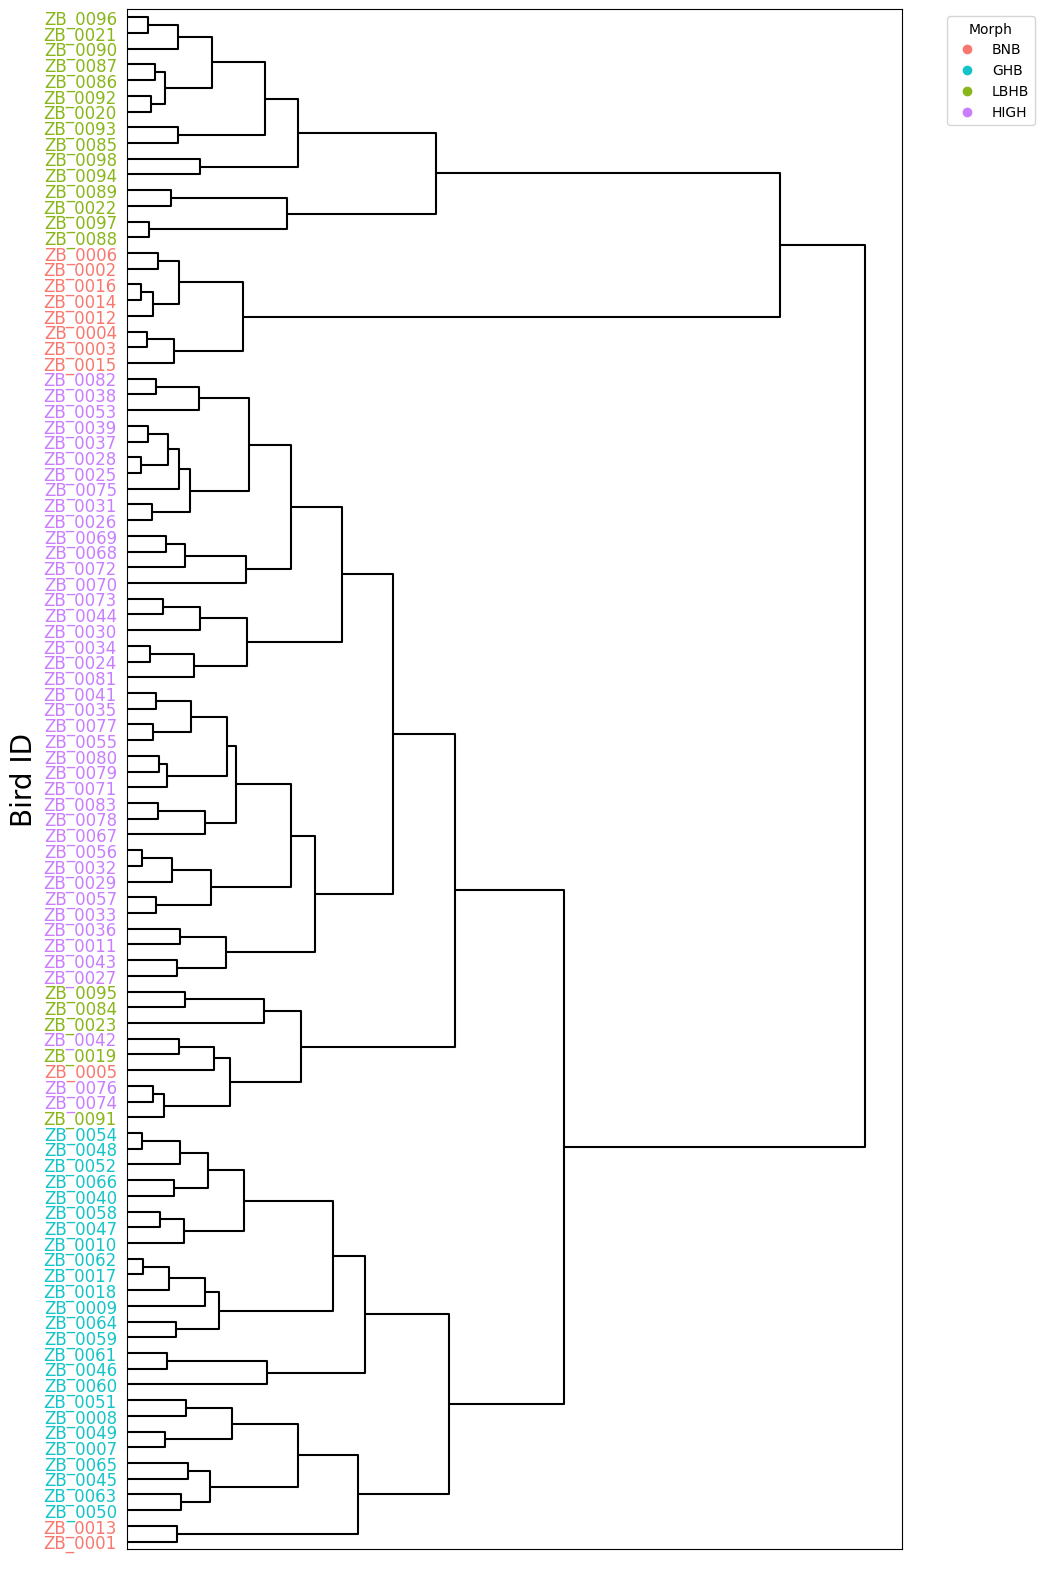

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap

# Perform hierarchical clustering
linkage_matrix = linkage(distance_df, method='complete')

# Map 'morph' values to colors for the leaves
colors = ["#f8786f", "#15c4c8", "#89b61b","#c87eff"]
morph_colors = {morph: color for morph, color in zip(final_df['morph'].unique(), colors)}
leaf_colors = {bird: morph_colors[final_df.loc[final_df['bird'] == bird, 'morph'].values[0]] for bird in distance_df.index}

# Custom color palette for dendrogram clusters
cmap = LinearSegmentedColormap.from_list('blues', ['#0D47A1', '#42A5F5'], N=256)

# Determine the major morph color for each cluster link
def get_major_morph_color(linkage_matrix, leaf_colors, final_df, num_leaves):
    link_cols = {}
    for i, (node1, node2, dist, _) in enumerate(linkage_matrix):
        node1, node2 = int(node1), int(node2)
        
        # Get leaves in the current cluster
        if node1 < num_leaves:
            leaves1 = [distance_df.index[node1]]
        else:
            leaves1 = link_cols[node1]['leaves']

        if node2 < num_leaves:
            leaves2 = [distance_df.index[node2]]
        else:
            leaves2 = link_cols[node2]['leaves']

        current_leaves = leaves1 + leaves2

        # Determine the most common morph color
        morph_counts = Counter(final_df.loc[final_df['bird'].isin(current_leaves), 'morph'])
        major_morph = morph_counts.most_common(1)[0][0]
        color = morph_colors[major_morph]

        link_cols[i + num_leaves] = {
            'color': color,
            'leaves': current_leaves
        }
    
    return {k: v['color'] for k, v in link_cols.items()}

# Get the link colors
color_threshold = max(linkage_matrix[:, 2]) * 0
num_leaves = len(distance_df.index)
link_colors = get_major_morph_color(linkage_matrix, leaf_colors, final_df, num_leaves)

# Plot the dendrogram
plt.figure(figsize=(10, 20))
dendro = dendrogram(
    linkage_matrix,
    labels=distance_df.index,
    leaf_rotation=0,  # Horizontal text
    leaf_font_size=12,  # Reduced font size
    above_threshold_color='black',
    color_threshold=color_threshold,
    orientation='right',
    link_color_func=lambda k: 'black' if linkage_matrix[k - num_leaves, 2] > color_threshold else link_colors.get(k, '#808080')  # Default to gray if not in link_colors
)

# Color the leaves
ax = plt.gca()
ylbls = ax.get_ymajorticklabels()  # For 'right' orientation, use y-axis labels
for lbl in ylbls:
    lbl.set_color(leaf_colors[lbl.get_text()])

# Create a custom legend
patches = [plt.Line2D([0], [0], color=color, marker='o', linestyle='') for color in morph_colors.values()]
plt.legend(patches, morph_colors.keys(), title="Morph", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlabel(' ')
plt.xticks([])
plt.ylabel('Bird ID', fontsize=20)

# Save the figure
plt.savefig('dendrogram_posteriors_sg.png', bbox_inches='tight', dpi=600)

plt.show()


In [111]:
filtered_data = final_df[final_df['cluster'] != -1][['bird', 'cluster']]
pivot_table = filtered_data.pivot_table(index='bird', columns='cluster', aggfunc=len, fill_value=0)
normalized_pivot = pivot_table.div(pivot_table.sum(axis=1), axis=0)

binary_matrix = normalized_pivot > 0
distance_matrix = pairwise_distances(binary_matrix, metric= jaccard)

birds = pivot_table.index
distance_df_jac = pd.DataFrame(distance_matrix, index=birds, columns=birds)

distance_df_jac

bird      ZB_0001   ZB_0002   ZB_0003   ZB_0004   ZB_0005   ZB_0006   ZB_0007  \
bird                                                                            
ZB_0001  0.000000  0.735294  0.756757  0.775000  0.830189  0.777778  0.975610   
ZB_0002  0.735294  0.000000  0.851852  0.827586  0.880952  0.750000  0.920000   
ZB_0003  0.756757  0.851852  0.000000  0.724138  0.780488  0.805556  0.846154   
ZB_0004  0.775000  0.827586  0.724138  0.000000  0.822222  0.789474  0.862069   
ZB_0005  0.830189  0.880952  0.780488  0.822222  0.000000  0.744681  0.904762   
...           ...       ...       ...       ...       ...       ...       ...   
ZB_0094  0.824561  0.893617  0.854167  0.884615  0.796610  0.769231  0.914894   
ZB_0095  0.761905  0.854545  0.800000  0.810345  0.828571  0.770492  0.872727   
ZB_0096  0.849057  0.850000  0.957447  0.869565  0.818182  0.711111  0.928571   
ZB_0097  0.821429  0.813953  0.875000  0.760870  0.771930  0.764706  0.888889   
ZB_0098  0.854167  0.974359  0.805556  0.878049  0.843137  0.844444  0.973684   

bird      ZB_0008   ZB_0009   ZB_0010  ...  ZB_0089m   ZB_0090   ZB_0091  \
bird                                   ...                                 
ZB_0001  0.756757  0.711538  0.833333  ...  0.830769  0.813559  0.846154   
ZB_0002  0.760000  0.761905  0.891892  ...  0.870370  0.854167  0.875000   
ZB_0003  0.827586  0.829787  0.900000  ...  0.915254  0.840000  0.800000   
ZB_0004  0.724138  0.739130  0.794872  ...  0.901639  0.826923  0.785714   
ZB_0005  0.809524  0.709091  0.867925  ...  0.769231  0.678571  0.792453   
...           ...       ...       ...  ...       ...       ...       ...   
ZB_0094  0.829787  0.711864  0.725490  ...  0.692308  0.803030  0.887097   
ZB_0095  0.842105  0.681818  0.754098  ...  0.567164  0.714286  0.750000   
ZB_0096  0.804878  0.679245  0.770833  ...  0.661017  0.672727  0.740000   
ZB_0097  0.800000  0.728814  0.720000  ...  0.687500  0.607143  0.666667   
ZB_0098  0.925000  0.745098  0.767442  ...  0.672727  0.824561  0.860000   

bird      ZB_0092   ZB_0093   ZB_0094   ZB_0095   ZB_0096   ZB_0097   ZB_0098  
bird                                                                           
ZB_0001  0.897959  0.768116  0.824561  0.761905  0.849057  0.821429  0.854167  
ZB_0002  0.885714  0.813559  0.893617  0.854545  0.850000  0.813953  0.974359  
ZB_0003  0.864865  0.822581  0.854167  0.800000  0.957447  0.875000  0.805556  
ZB_0004  0.902439  0.812500  0.884615  0.810345  0.869565  0.760870  0.878049  
ZB_0005  0.711111  0.728571  0.796610  0.828571  0.818182  0.771930  0.843137  
...           ...       ...       ...       ...       ...       ...       ...  
ZB_0094  0.833333  0.676056  0.000000  0.619048  0.703704  0.770492  0.720000  
ZB_0095  0.806452  0.670886  0.619048  0.000000  0.672131  0.634921  0.611111  
ZB_0096  0.787234  0.705882  0.703704  0.672131  0.000000  0.591837  0.765957  
ZB_0097  0.708333  0.652174  0.770492  0.634921  0.591837  0.000000  0.811321  
ZB_0098  0.914894  0.811594  0.720000  0.611111  0.765957  0.811321  0.000000  

[101 rows x 101 columns]

In [ ]:
# K-Means

### Euclidean

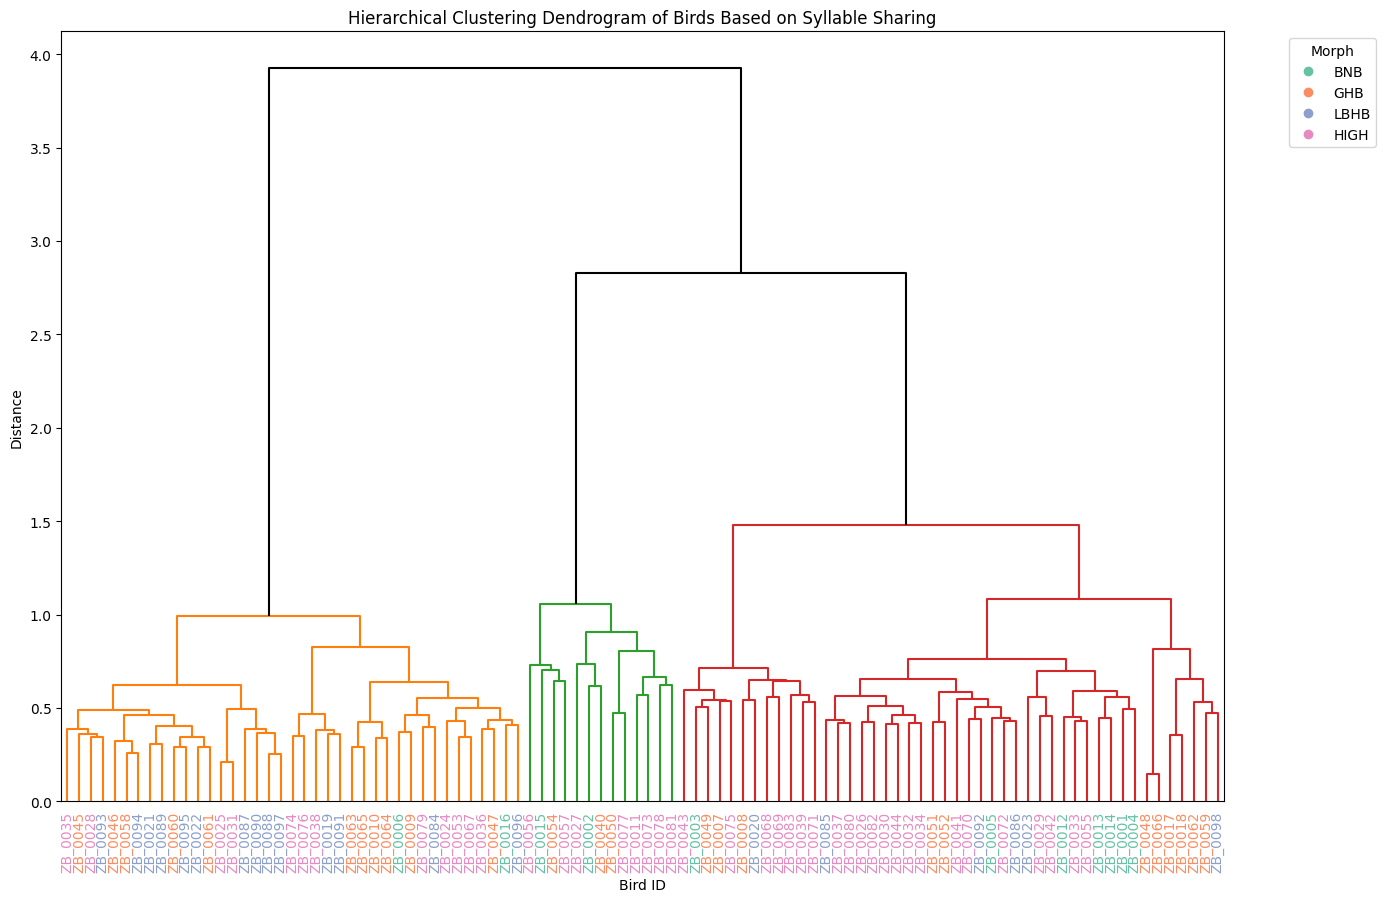

In [51]:
linkage_matrix = linkage(distance_df_euc, method='ward')

# Map 'morph' values to colors for the leaves
morph_colors = {morph: color for morph, color in zip(final_df['morph'].unique(), plt.cm.Set2.colors)}
leaf_colors = {bird: morph_colors[final_df.loc[final_df['bird'] == bird, 'morph'].values[0]] for bird in distance_df_euc.index}

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendro = dendrogram(
    linkage_matrix,
    labels=distance_df_euc.index,
    leaf_rotation=90,
    leaf_font_size=10,
    above_threshold_color='black',
    color_threshold=max(linkage_matrix[:, 2]) * 0.42

)

# Color the leaves
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(leaf_colors[lbl.get_text()])

patches = [plt.Line2D([0], [0], color=color, marker='o', linestyle='') for color in morph_colors.values()]
plt.legend(patches, morph_colors.keys(), title="Morph", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Hierarchical Clustering Dendrogram of Birds Based on Syllable Sharing')
plt.xlabel('Bird ID')
plt.ylabel('Distance')
plt.show()

### Jaccard

/var/folders/12/ks7q36dj491dw0thmdw9zz_40000gn/T/ipykernel_35495/527313299.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_df_jac, method='ward')


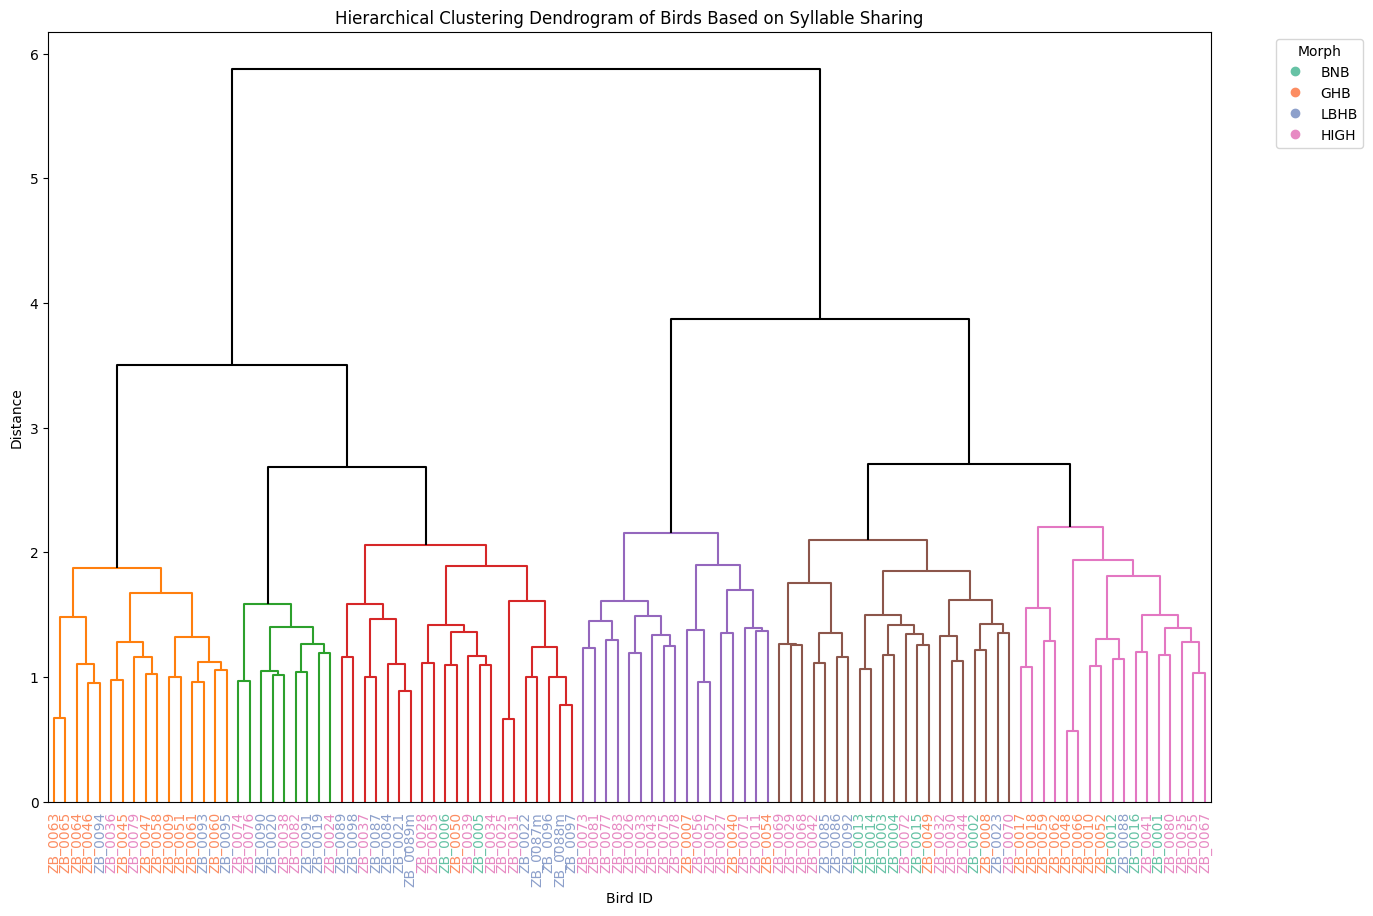

In [112]:
linkage_matrix = linkage(distance_df_jac, method='ward')

# Map 'morph' values to colors for the leaves
morph_colors = {morph: color for morph, color in zip(final_df['morph'].unique(), plt.cm.Set2.colors)}
leaf_colors = {bird: morph_colors[final_df.loc[final_df['bird'] == bird, 'morph'].values[0]] for bird in distance_df_jac.index}

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendro = dendrogram(
    linkage_matrix,
    labels=distance_df_jac.index,
    leaf_rotation=90,
    leaf_font_size=10,
    above_threshold_color='black',
    color_threshold=max(linkage_matrix[:, 2]) * 0.4

)

# Color the leaves
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(leaf_colors[lbl.get_text()])

patches = [plt.Line2D([0], [0], color=color, marker='o', linestyle='') for color in morph_colors.values()]
plt.legend(patches, morph_colors.keys(), title="Morph", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Hierarchical Clustering Dendrogram of Birds Based on Syllable Sharing')
plt.xlabel('Bird ID')
plt.ylabel('Distance')
plt.show()

/var/folders/12/ks7q36dj491dw0thmdw9zz_40000gn/T/ipykernel_35495/2474263731.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_df_jac, method='ward')


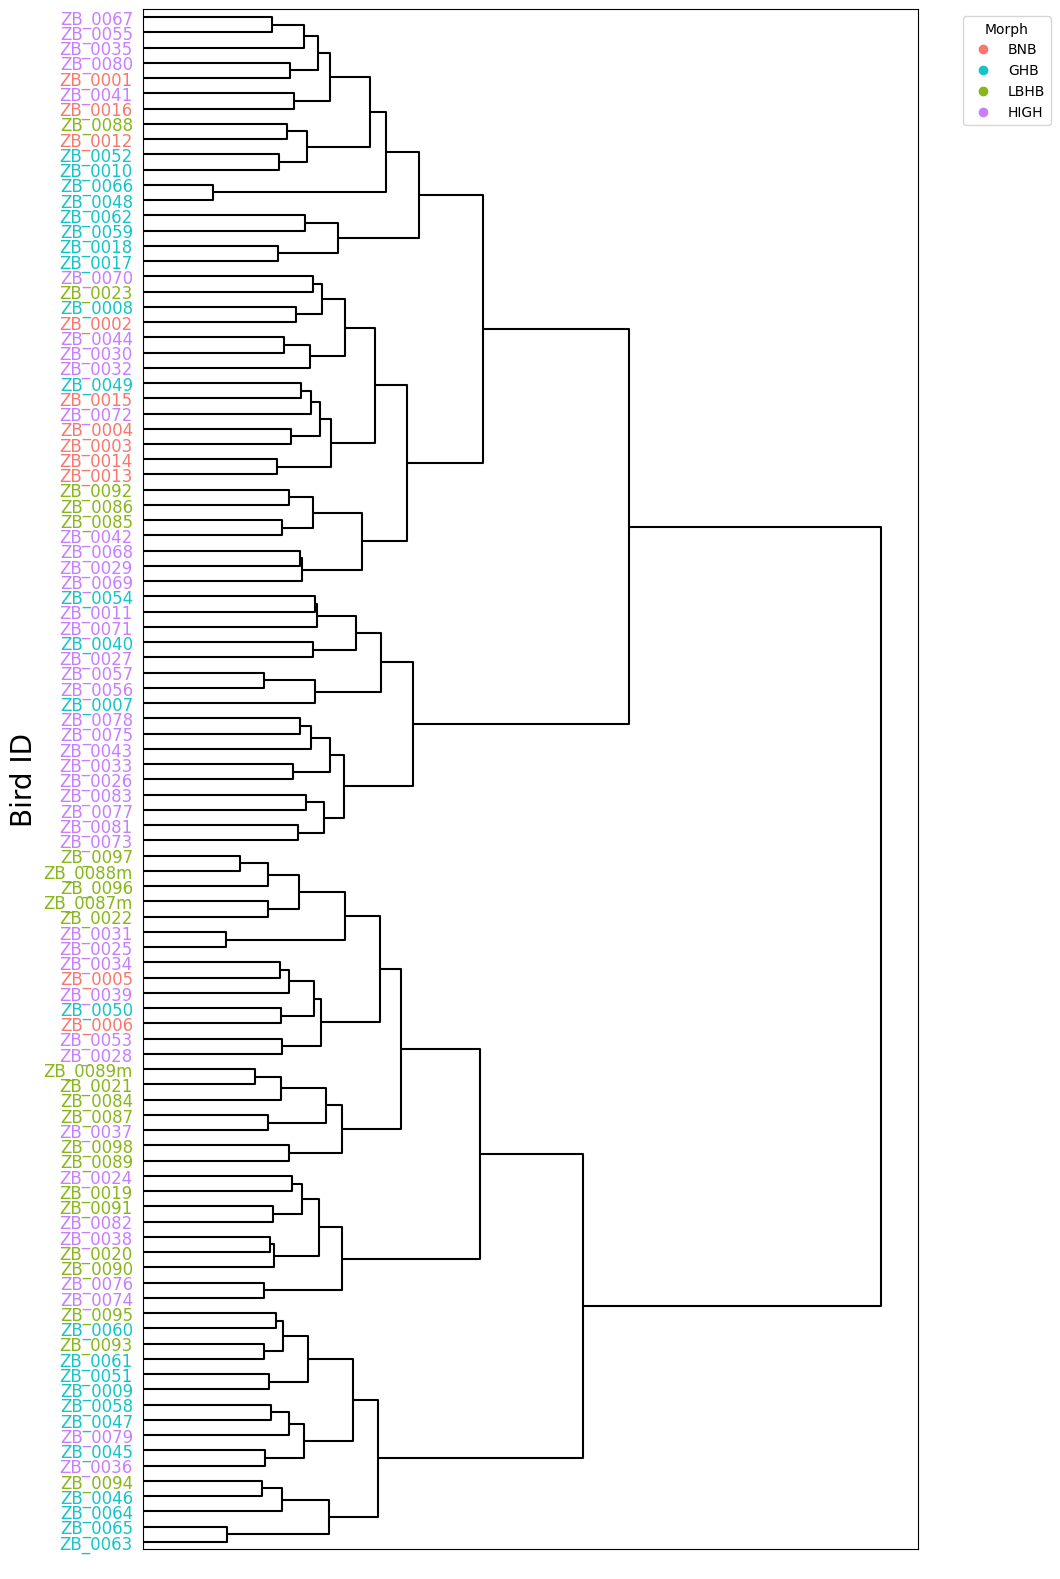

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap

# Perform hierarchical clustering
linkage_matrix = linkage(distance_df_jac, method='ward')

# Map 'morph' values to colors for the leaves
colors = ["#f8786f", "#15c4c8", "#89b61b","#c87eff"]
morph_colors = {morph: color for morph, color in zip(final_df['morph'].unique(), colors)}
leaf_colors = {bird: morph_colors[final_df.loc[final_df['bird'] == bird, 'morph'].values[0]] for bird in distance_df_jac.index}

# Custom color palette for dendrogram clusters
cmap = LinearSegmentedColormap.from_list('blues', ['#0D47A1', '#42A5F5'], N=256)

# Determine the major morph color for each cluster link
def get_major_morph_color(linkage_matrix, leaf_colors, final_df, num_leaves):
    link_cols = {}
    for i, (node1, node2, dist, _) in enumerate(linkage_matrix):
        node1, node2 = int(node1), int(node2)
        
        # Get leaves in the current cluster
        if node1 < num_leaves:
            leaves1 = [distance_df_jac.index[node1]]
        else:
            leaves1 = link_cols[node1]['leaves']

        if node2 < num_leaves:
            leaves2 = [distance_df_jac.index[node2]]
        else:
            leaves2 = link_cols[node2]['leaves']

        current_leaves = leaves1 + leaves2

        # Determine the most common morph color
        morph_counts = Counter(final_df.loc[final_df['bird'].isin(current_leaves), 'morph'])
        major_morph = morph_counts.most_common(1)[0][0]
        color = morph_colors[major_morph]

        link_cols[i + num_leaves] = {
            'color': color,
            'leaves': current_leaves
        }
    
    return {k: v['color'] for k, v in link_cols.items()}

# Get the link colors
color_threshold = max(linkage_matrix[:, 2]) * 0
num_leaves = len(distance_df_jac.index)
link_colors = get_major_morph_color(linkage_matrix, leaf_colors, final_df, num_leaves)

# Plot the dendrogram
plt.figure(figsize=(10, 20))
dendro = dendrogram(
    linkage_matrix,
    labels=distance_df_jac.index,
    leaf_rotation=0,  # Horizontal text
    leaf_font_size=12,  # Reduced font size
    above_threshold_color='black',
    color_threshold=color_threshold,
    orientation='right',
    link_color_func=lambda k: 'black' if linkage_matrix[k - num_leaves, 2] > color_threshold else link_colors.get(k, '#808080')  # Default to gray if not in link_colors
)

# Color the leaves
ax = plt.gca()
ylbls = ax.get_ymajorticklabels()  # For 'right' orientation, use y-axis labels
for lbl in ylbls:
    lbl.set_color(leaf_colors[lbl.get_text()])

# Create a custom legend
patches = [plt.Line2D([0], [0], color=color, marker='o', linestyle='') for color in morph_colors.values()]
plt.legend(patches, morph_colors.keys(), title="Morph", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the title and labels
plt.xlabel(' ')
plt.xticks([])
plt.ylabel('Bird ID', fontsize=20)

# Save the figure
plt.savefig('dendrogram.png', bbox_inches='tight', dpi=600)

plt.show()


from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt


linkage_matrix = linkage(distance_df_jac, method='ward')
color_threshold = max(linkage_matrix[:, 2]) * 0.4
clusters = fcluster(linkage_matrix, color_threshold, criterion='distance')

label_cluster_map = {label: cluster for label, cluster in zip(distance_df_jac.index, clusters)}

final_df['cluster_dendo'] = final_df['bird'].map(label_cluster_map)

cluster_morph_count = final_df.groupby(['cluster_dendo', 'morph']).size().unstack(fill_value=0)

# Ensure the columns are in the specific order
ordered_morphs = ['BNB', 'GHB', 'LBHB', 'HIGH']
cluster_morph_proportion = cluster_morph_count[ordered_morphs]

cluster_morph_proportion = cluster_morph_proportion.div(cluster_morph_proportion.sum(axis=1), axis=0)

# Colors corresponding to each morph in the specified order
colors = ["#f8786f", "#15c4c8", "#c87eff", "#89b61b"]

# Apply the colors to the plot
cluster_morph_proportion.plot(kind='bar', stacked=True, color=colors)
plt.title("Proportion of Each Morph by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion")

# Move the legend outside of the plot
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.savefig('kmeans_histo.png', dpi=600, edgecolor='none', bbox_inches='tight')

plt.show()


/var/folders/12/ks7q36dj491dw0thmdw9zz_40000gn/T/ipykernel_99456/1148034650.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_df_jac, method='ward')


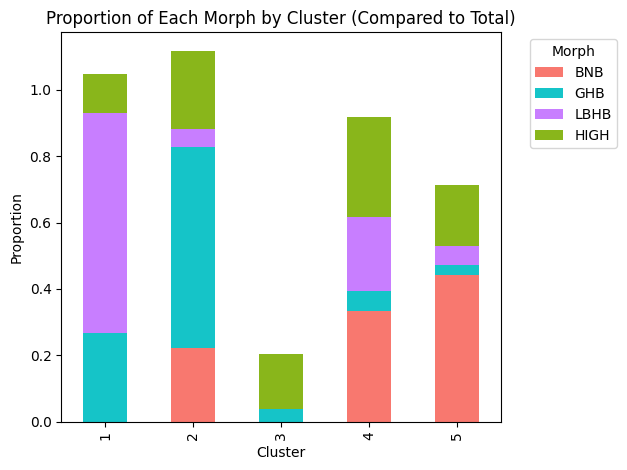

In [54]:
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
import pandas as pd

# Assume distance_df_jac and final_df are already defined

# Perform hierarchical clustering
linkage_matrix = linkage(distance_df_jac, method='ward')
color_threshold = max(linkage_matrix[:, 2]) * 0.4
clusters = fcluster(linkage_matrix, color_threshold, criterion='distance')

# Map each bird to its cluster
label_cluster_map = {label: cluster for label, cluster in zip(distance_df_jac.index, clusters)}
final_df['cluster_dendo'] = final_df['bird'].map(label_cluster_map)

# Count the number of each morph in each cluster
cluster_morph_count = final_df.groupby(['cluster_dendo', 'morph']).size().unstack(fill_value=0)

# Ensure the columns are in the specific order
ordered_morphs = ['BNB', 'GHB', 'LBHB', 'HIGH']
cluster_morph_count = cluster_morph_count[ordered_morphs]

# Calculate the proportion of each morph compared to the total number of birds
total_morph_count = final_df['morph'].value_counts()[ordered_morphs]
cluster_morph_proportion = cluster_morph_count.div(total_morph_count, axis=1)

# Colors corresponding to each morph in the specified order
colors = ["#f8786f", "#15c4c8", "#c87eff", "#89b61b"]

# Plot the proportions
cluster_morph_proportion.plot(kind='bar', stacked=True, color=colors)
plt.title("Proportion of Each Morph by Cluster (Compared to Total)")
plt.xlabel("Cluster")
plt.ylabel("Proportion")

# Move the legend outside of the plot
plt.legend(title='Morph', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.savefig('dendrogram_morph_proportion_total.png', dpi=600, edgecolor='none', bbox_inches='tight')

plt.show()


/var/folders/12/ks7q36dj491dw0thmdw9zz_40000gn/T/ipykernel_99456/3473451029.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_df_jac, method='ward')


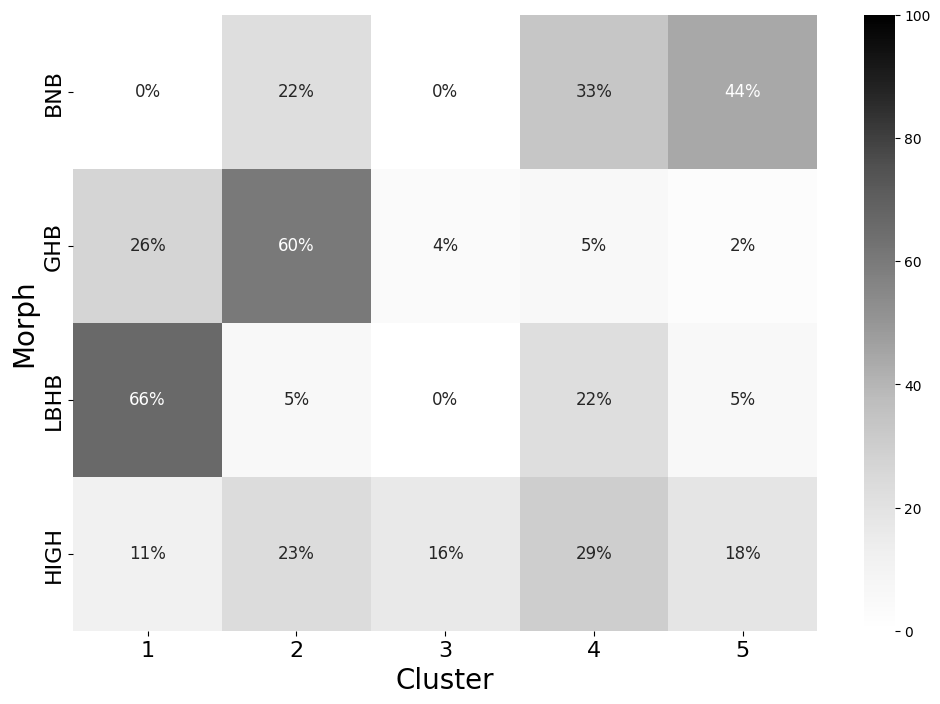

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd

# Assume distance_df_jac and final_df are already defined

# Perform hierarchical clustering
linkage_matrix = linkage(distance_df_jac, method='ward')
color_threshold = max(linkage_matrix[:, 2]) * 0.4
clusters = fcluster(linkage_matrix, color_threshold, criterion='distance')

# Map each bird to its cluster
label_cluster_map = {label: cluster for label, cluster in zip(distance_df_jac.index, clusters)}
final_df['cluster_dendo'] = final_df['bird'].map(label_cluster_map)

# Count the number of each morph in each cluster
cluster_morph_count = final_df.groupby(['cluster_dendo', 'morph']).size().unstack(fill_value=0)

# Ensure the columns are in the specific order
ordered_morphs = ['BNB', 'GHB', 'LBHB', 'HIGH']
cluster_morph_count = cluster_morph_count[ordered_morphs]

# Calculate the total count of each morph
total_morph_count = final_df['morph'].value_counts()[ordered_morphs]

# Calculate the proportion of each morph in each cluster compared to its total count
cluster_morph_proportion = cluster_morph_count.div(total_morph_count, axis=1) * 100

# Create a heatmap with whole percentage annotations
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_morph_proportion.T, annot=cluster_morph_proportion.T.applymap(lambda x: f"{int(x)}%"), fmt='', cmap="Greys", vmin=0, vmax=100, annot_kws={"fontsize":14})
plt.xlabel("Cluster", fontsize=20)
plt.ylabel("Morph", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save the figure
plt.savefig('dendrogram_morph_proportion_heatmap.png', dpi=600, edgecolor='none', bbox_inches='tight')

plt.show()


prop tot

In [71]:
syllable_data = final_df[final_df['clusters'] != -1][['morph', 'pop_code', 'bird', 'syllable', 'clusters', 'cluster_dendo']]
dict_rename = {#'file_name': 'song',
        'clusters': 'syllable_type'}
 
syllable_data.rename(columns=dict_rename,
          inplace=True)

In [72]:
syllable_data

morph pop_code     bird                           syllable  \
0      BNB     TREM  ZB_0005  S10_ZB_0005_211105_001.WAV_10.wav   
1      BNB     TREM  ZB_0005   S10_ZB_0005_211105_001.WAV_3.wav   
2      BNB     TREM  ZB_0005   S10_ZB_0005_211105_001.WAV_5.wav   
3      BNB     TREM  ZB_0005   S10_ZB_0005_211105_001.WAV_6.wav   
4      BNB     TREM  ZB_0005   S10_ZB_0005_211105_002.WAV_3.wav   
...    ...      ...      ...                                ...   
9114  LBHB     SGBA  ZB_0097          S9_ZB_0097_1219.WAV_5.wav   
9115  LBHB     SGBA  ZB_0097          S9_ZB_0097_1219.WAV_6.wav   
9116  LBHB     SGBA  ZB_0097          S9_ZB_0097_1219.WAV_7.wav   
9117  LBHB     SGBA  ZB_0097          S9_ZB_0097_1219.WAV_8.wav   
9118  LBHB     SGBA  ZB_0097          S9_ZB_0097_1219.WAV_9.wav   

      syllable_type  cluster_dendo  
0               123              4  
1                41              4  
2                89              4  
3                89              4  
4                72              4  
...             ...            ...  
9114             17              1  
9115              4              1  
9116             72              1  
9117            100              1  
9118            106              1  

[9119 rows x 6 columns]

In [74]:
counts_per_syllable = syllable_data.groupby(['syllable', 'syllable_type']).size().unstack(fill_value=0)
syllable_bird_morph = syllable_data[['syllable', 'bird', 'pop_code','morph', 'cluster_dendo']].drop_duplicates().set_index('syllable')
syllable_data = counts_per_syllable.join(syllable_bird_morph)

In [75]:
syllable_data

0  1  2  3  4  5  6  7  8  9  ...  119  \
syllable                                                         ...        
S10_ZB_0005_211105_001.WAV_10.wav  0  0  0  0  0  0  0  0  0  0  ...    0   
S10_ZB_0005_211105_001.WAV_3.wav   0  0  0  0  0  0  0  0  0  0  ...    0   
S10_ZB_0005_211105_001.WAV_5.wav   0  0  0  0  0  0  0  0  0  0  ...    0   
S10_ZB_0005_211105_001.WAV_6.wav   0  0  0  0  0  0  0  0  0  0  ...    0   
S10_ZB_0005_211105_002.WAV_3.wav   0  0  0  0  0  0  0  0  0  0  ...    0   
...                               .. .. .. .. .. .. .. .. .. ..  ...  ...   
S9_ZB_0097_1219.WAV_5.wav          0  0  0  0  0  0  0  0  0  0  ...    0   
S9_ZB_0097_1219.WAV_6.wav          0  0  0  0  1  0  0  0  0  0  ...    0   
S9_ZB_0097_1219.WAV_7.wav          0  0  0  0  0  0  0  0  0  0  ...    0   
S9_ZB_0097_1219.WAV_8.wav          0  0  0  0  0  0  0  0  0  0  ...    0   
S9_ZB_0097_1219.WAV_9.wav          0  0  0  0  0  0  0  0  0  0  ...    0   

                                   120  121  122  123  124     bird  pop_code  \
syllable                                                                        
S10_ZB_0005_211105_001.WAV_10.wav    0    0    0    1    0  ZB_0005      TREM   
S10_ZB_0005_211105_001.WAV_3.wav     0    0    0    0    0  ZB_0005      TREM   
S10_ZB_0005_211105_001.WAV_5.wav     0    0    0    0    0  ZB_0005      TREM   
S10_ZB_0005_211105_001.WAV_6.wav     0    0    0    0    0  ZB_0005      TREM   
S10_ZB_0005_211105_002.WAV_3.wav     0    0    0    0    0  ZB_0005      TREM   
...                                ...  ...  ...  ...  ...      ...       ...   
S9_ZB_0097_1219.WAV_5.wav            0    0    0    0    0  ZB_0097      SGBA   
S9_ZB_0097_1219.WAV_6.wav            0    0    0    0    0  ZB_0097      SGBA   
S9_ZB_0097_1219.WAV_7.wav            0    0    0    0    0  ZB_0097      SGBA   
S9_ZB_0097_1219.WAV_8.wav            0    0    0    0    0  ZB_0097      SGBA   
S9_ZB_0097_1219.WAV_9.wav            0    0    0    0    0  ZB_0097      SGBA   

                                   morph  cluster_dendo  
syllable                                                 
S10_ZB_0005_211105_001.WAV_10.wav    BNB              4  
S10_ZB_0005_211105_001.WAV_3.wav     BNB              4  
S10_ZB_0005_211105_001.WAV_5.wav     BNB              4  
S10_ZB_0005_211105_001.WAV_6.wav     BNB              4  
S10_ZB_0005_211105_002.WAV_3.wav     BNB              4  
...                                  ...            ...  
S9_ZB_0097_1219.WAV_5.wav           LBHB              1  
S9_ZB_0097_1219.WAV_6.wav           LBHB              1  
S9_ZB_0097_1219.WAV_7.wav           LBHB              1  
S9_ZB_0097_1219.WAV_8.wav           LBHB              1  
S9_ZB_0097_1219.WAV_9.wav           LBHB              1  

[9119 rows x 129 columns]

In [76]:
syllable_data.to_csv('syllable_data_final.csv')

final_df.to_csv('final_df_contour.csv')

- Pourquoi l'average t-SNE est juste rotationée? 
- Classique et Silence PCA pour le clustering avant d'appliqer UMAP et T-SNE? pas fait avant
- Classique et Silence PCA pour la classification? 
- Jusqu'où on s'arrête? Aux distances acoustiques 